<a href="https://colab.research.google.com/github/dmw2101/bits_wabt/blob/main/test-1/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import AutoTokenizer, AutoModel
from torchvision import datasets, transforms
import torch

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MiniLM
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
model = AutoModel.from_pretrained("microsoft/MiniLM-L12-H384-uncased").to(device)

# Label → Text Prompt
label_to_text = {
    0: "a T-shirt",
    1: "a pair of trousers",
    2: "a pullover",
    3: "a dress",
    4: "a coat",
    5: "a sandal",
    6: "a shirt",
    7: "a sneaker",
    8: "a bag",
    9: "an ankle boot"
}

# Dataset + Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert 1-channel to 3
])
dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Loop through data
for images, labels in loader:
    # Get corresponding text prompts
    texts = [label_to_text[label.item()] for label in labels]

    # Tokenize
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)

    # Encode
    with torch.no_grad():  # optional during inference / debugging
        outputs = model(**inputs)

    # Get encoded text (last_hidden_state or pooled_output)
    encodings = outputs.last_hidden_state  # shape: (B, seq_len, 384)

    print("Encoded text shape:", encodings.shape)
    break  # Remove this break to use in full training loop


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Encoded text shape: torch.Size([16, 6, 384])


In [2]:
import requests
r = requests.get("https://huggingface.co/google/vit-small-patch16-224")
print("Status Code:", r.status_code)


Status Code: 401


In [3]:
print("Tokenized input shape:", inputs["input_ids"].shape)
# Should be (batch_size, seq_len) — e.g., (16, 7)

outputs = model(**inputs)
print("Last hidden state shape:", outputs.last_hidden_state.shape)
# Should be (batch_size, seq_len, hidden_dim) — e.g., (16, 7, 384)
print("Sample labels:", labels)
print("Text prompts:", texts)  # Should be a list of length 16

Tokenized input shape: torch.Size([16, 6])
Last hidden state shape: torch.Size([16, 6, 384])
Sample labels: tensor([9, 0, 0, 2, 4, 1, 2, 8, 6, 3, 0, 2, 6, 1, 8, 8])
Text prompts: ['an ankle boot', 'a T-shirt', 'a T-shirt', 'a pullover', 'a coat', 'a pair of trousers', 'a pullover', 'a bag', 'a shirt', 'a dress', 'a T-shirt', 'a pullover', 'a shirt', 'a pair of trousers', 'a bag', 'a bag']


In [4]:
from getpass import getpass
from huggingface_hub import login, whoami

# Prompt for token securely
hf_token = getpass("🔐 Enter your Hugging Face token: ")

# Log in to Hugging Face
login(token=hf_token)

# Fetch and display user info to confirm
user_info = whoami()
print("✅ Logged in successfully!")
print(f"👤 Username: {user_info['name']}")
print(f"📛 Type: {user_info['type']}")


🔐 Enter your Hugging Face token: ··········
✅ Logged in successfully!
👤 Username: menon123
📛 Type: user


In [5]:
import torch
from torchvision import datasets, transforms
from transformers import CLIPProcessor, CLIPModel

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CLIP model (ViT-B/32)
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# Fashion-MNIST transform (resized + 3-channel for CLIP)
transform = transforms.Compose([
    transforms.Resize((224, 224)),                     # CLIP expects 224x224
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))     # Convert grayscale (1C) to RGB (3C)
])

# Load dataset
dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Process one batch
for images, labels in loader:
    # Process images using CLIP processor
    inputs = clip_processor(images=images, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)  # returns (B, 512)

    image_embeddings = outputs  # shape: (16, 512)
    print("CLIP Image Embeddings shape:", image_embeddings.shape)
    break  # remove in actual training loop
projector = torch.nn.Linear(512, 384).to(device)
image_embeddings = projector(image_embeddings)
print(image_embeddings.shape)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


CLIP Image Embeddings shape: torch.Size([16, 512])
torch.Size([16, 384])


In [6]:
# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define model AFTER device
model = BottleneckAttention().to(device)

# 3. Move all inputs to device
image_tokens = image_tokens.to(device)
text_tokens = text_tokens.to(device)

# 4. Forward pass
fused_output = model(image_tokens, text_tokens)


NameError: name 'BottleneckAttention' is not defined

In [7]:
import torch
import torch.nn as nn

class BottleneckAttention(nn.Module):
    def __init__(self, dim=384, num_heads=6, num_bottlenecks=4):
        super().__init__()
        self.bottleneck_tokens = nn.Parameter(torch.randn(1, num_bottlenecks, dim))
        self.cross_attn_img = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.cross_attn_txt = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

    def forward(self, image_tokens, text_tokens):
        # 1. Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 2. Define model AFTER device
        model = BottleneckAttention().to(device)

        # 3. Move all inputs to device
        image_tokens = image_tokens.to(device)
        text_tokens = text_tokens.to(device)

        # 4. Forward pass
        fused_output = model(image_tokens, text_tokens)

        #debugging
        print(f"bottleneck_tokens: {self.bottleneck_tokens.device}")
        print(f"cross_attn_img.in_proj_weight: {self.cross_attn_img.in_proj_weight.device}")
        print(f"cross_attn_txt.in_proj_weight: {self.cross_attn_txt.in_proj_weight.device}")

        B = image_tokens.shape[0]

        # Expand bottleneck tokens to batch size
        bottlenecks = self.bottleneck_tokens.expand(B, -1, -1)  # [B, B₀, D]

        # --- Step 1: Tokens → Bottlenecks (Tokens attend to bottlenecks)
        # Image attends to bottlenecks
        img_out, _ = self.cross_attn_img(query=image_tokens, key=bottlenecks, value=bottlenecks)

        # Text attends to bottlenecks
        txt_out, _ = self.cross_attn_txt(query=text_tokens, key=bottlenecks, value=bottlenecks)

        # --- Step 2: Bottlenecks → Tokens (Bottlenecks attend to each modality)
        # Bottlenecks attend to image
        bn_img, _ = self.cross_attn_img(query=bottlenecks, key=img_out, value=img_out)

        # Bottlenecks attend to text
        bn_txt, _ = self.cross_attn_txt(query=bottlenecks, key=txt_out, value=txt_out)

        # Combine (optional: sum, cat, etc.)
        fused = bn_img + bn_txt  # [B, B₀, D]

        return fused


In [8]:
import torch

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Create dummy inputs or your actual embeddings
batch_size = 16
image_tokens = image_embeddings.unsqueeze(0).expand(16, -1, -1).to(device)  # shape: [16, 16, 384]
text_tokens = encodings.to(device)  # assume shape: [16, 6, 384]

# ✅ Recreate the model AFTER setting device
model = BottleneckAttention(dim=384, num_heads=6, num_bottlenecks=4).to(device)

# ✅ Forward pass
fused_output = model(image_tokens, text_tokens)

# ✅ Print device diagnostics
print(f"Model device: {next(model.parameters()).device}")
print(f"Image device: {image_tokens.device}")
print(f"Text device: {text_tokens.device}")
print(f"Image shape: {image_tokens.shape}")
print(f"Text shape: {text_tokens.shape}")

# ✅ Convert for visualization
bottleneck_tokens = fused_output[0].detach().cpu().numpy()
text_embeddings = text_tokens[0].detach().cpu().numpy()
image_embeddings = image_tokens[0].detach().cpu().numpy()

print("Bottleneck shape:", bottleneck_tokens.shape)
print("Text shape:", text_embeddings.shape)
print("Image shape:", image_embeddings.shape)


Using device: cuda


RecursionError: maximum recursion depth exceeded in __instancecheck__

In [9]:
import torch
import torch.nn as nn

class BottleneckAttention(nn.Module):
    def __init__(self, dim=384, num_heads=6, num_bottlenecks=4):
        super().__init__()
        self.bottleneck_tokens = nn.Parameter(torch.randn(1, num_bottlenecks, dim))
        self.cross_attn_img = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.cross_attn_txt = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

    def forward(self, image_tokens, text_tokens):
        # Optional: Ensure bottleneck tokens are on the same device
        self.bottleneck_tokens = self.bottleneck_tokens.to(image_tokens.device)

        # Debug prints
        print(f"bottleneck_tokens: {self.bottleneck_tokens.device}")
        print(f"cross_attn_img.in_proj_weight: {self.cross_attn_img.in_proj_weight.device}")
        print(f"cross_attn_txt.in_proj_weight: {self.cross_attn_txt.in_proj_weight.device}")

        B = image_tokens.shape[0]

        # Expand bottleneck tokens to match batch size
        bottlenecks = self.bottleneck_tokens.expand(B, -1, -1)  # [B, B₀, D]

        # --- Step 1: Tokens → Bottlenecks
        img_out, _ = self.cross_attn_img(query=image_tokens, key=bottlenecks, value=bottlenecks)
        txt_out, _ = self.cross_attn_txt(query=text_tokens, key=bottlenecks, value=bottlenecks)

        # --- Step 2: Bottlenecks → Tokens
        bn_img, _ = self.cross_attn_img(query=bottlenecks, key=img_out, value=img_out)
        bn_txt, _ = self.cross_attn_txt(query=bottlenecks, key=txt_out, value=txt_out)

        fused = bn_img + bn_txt  # Combine
        return fused


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarities_heatmap(b_tokens, text_emb, image_emb, epoch):
    sim_bt = cosine_similarity(b_tokens.detach().cpu().numpy(), text_emb.detach().cpu().numpy())
    sim_bv = cosine_similarity(b_tokens.detach().cpu().numpy(), image_emb.detach().cpu().numpy())

    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    sns.heatmap(sim_bt, ax=axes[0], cmap="viridis")
    axes[0].set_title(f"Bottleneck vs Text Similarity (Epoch {epoch})")

    sns.heatmap(sim_bv, ax=axes[1], cmap="viridis")
    axes[1].set_title(f"Bottleneck vs Image Similarity (Epoch {epoch})")
    plt.tight_layout()
    plt.show()


bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 1] Loss: 625.9263 | Bottleneck STD: 0.009794 | Mean Similarity: 0.9767 | Div Loss: 0.891457 | Var Loss: 0.000206
Avg max sim to text:  0.1039
Avg max sim to image: 0.0986


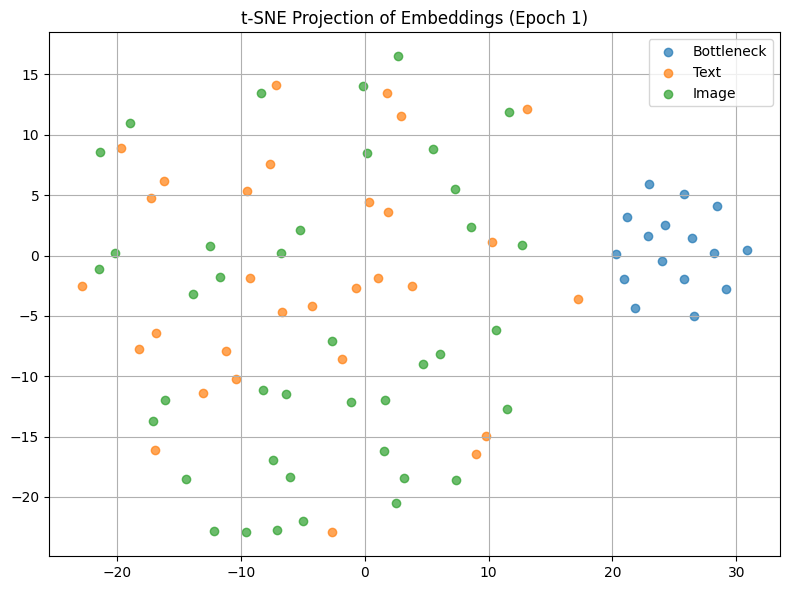

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 2] Loss: 632.9344 | Bottleneck STD: 0.009784 | Mean Similarity: 0.9818 | Div Loss: 0.901408 | Var Loss: 0.000216
Avg max sim to text:  0.1068
Avg max sim to image: 0.1010


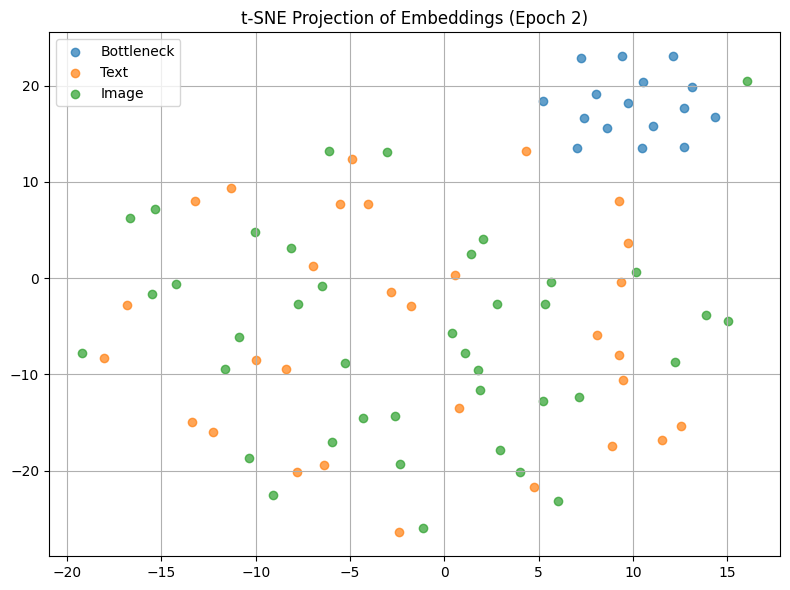

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 3] Loss: 577.2089 | Bottleneck STD: 0.009832 | Mean Similarity: 0.9402 | Div Loss: 0.821774 | Var Loss: 0.000168
Avg max sim to text:  0.0867
Avg max sim to image: 0.0951


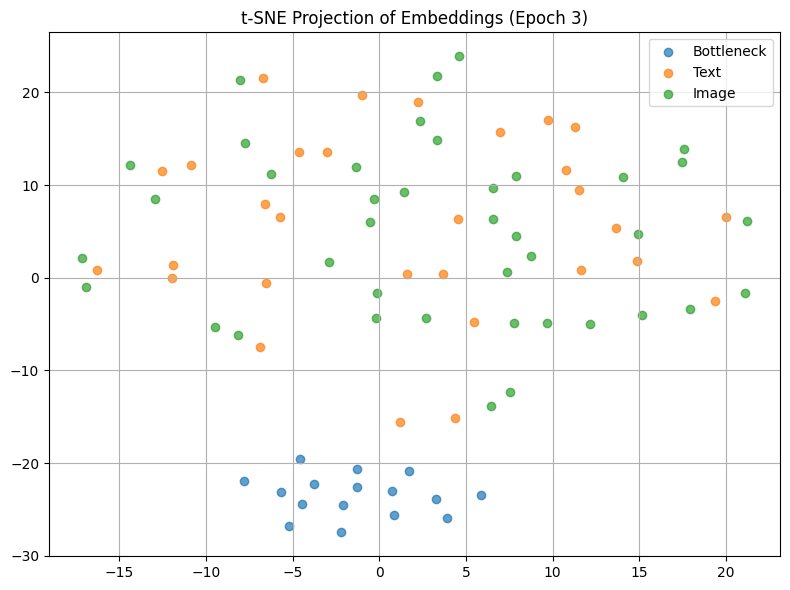

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 4] Loss: 556.9722 | Bottleneck STD: 0.009863 | Mean Similarity: 0.9247 | Div Loss: 0.792907 | Var Loss: 0.000137
Avg max sim to text:  0.0823
Avg max sim to image: 0.0891


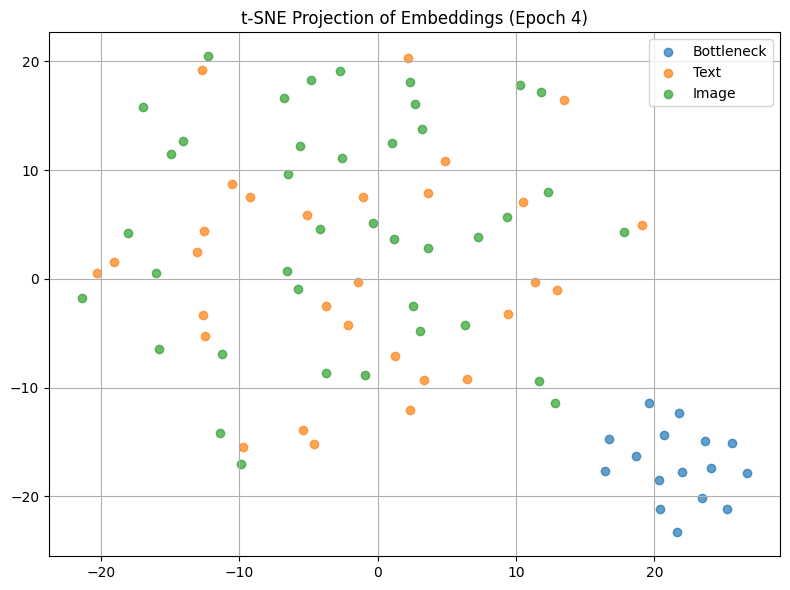

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 5] Loss: 549.4080 | Bottleneck STD: 0.009970 | Mean Similarity: 0.9186 | Div Loss: 0.781827 | Var Loss: 0.000030
Avg max sim to text:  0.0826
Avg max sim to image: 0.0729


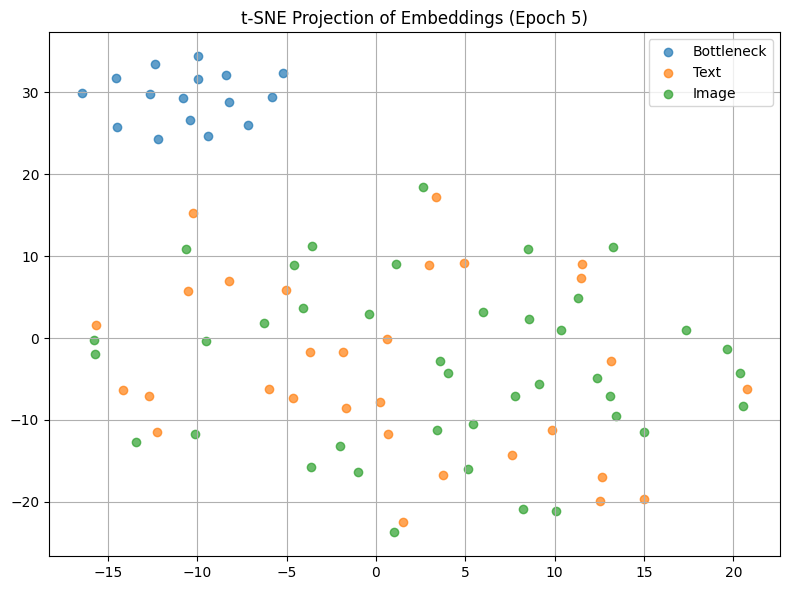

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 6] Loss: 401.9610 | Bottleneck STD: 0.009874 | Mean Similarity: 0.7941 | Div Loss: 0.571195 | Var Loss: 0.000126
Avg max sim to text:  0.0786
Avg max sim to image: 0.1280


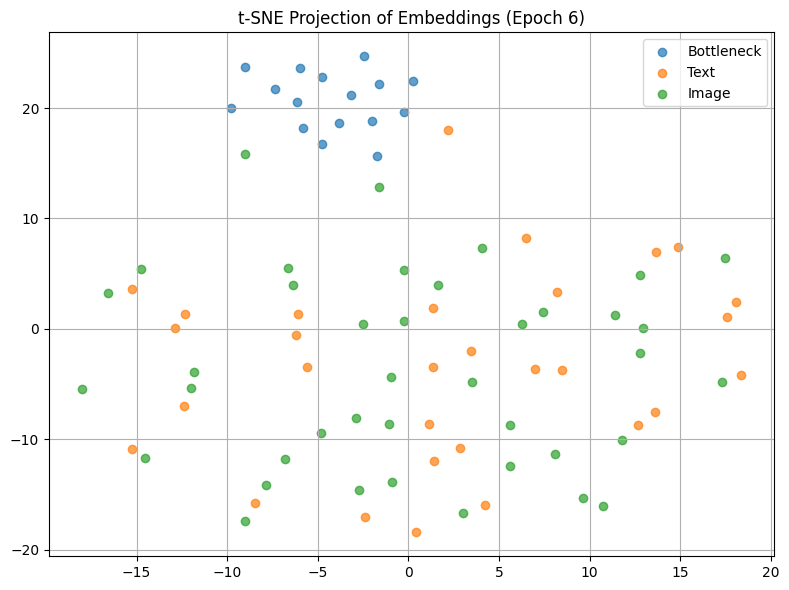

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 7] Loss: 474.1393 | Bottleneck STD: 0.009929 | Mean Similarity: 0.8578 | Div Loss: 0.674708 | Var Loss: 0.000071
Avg max sim to text:  0.1434
Avg max sim to image: 0.1292


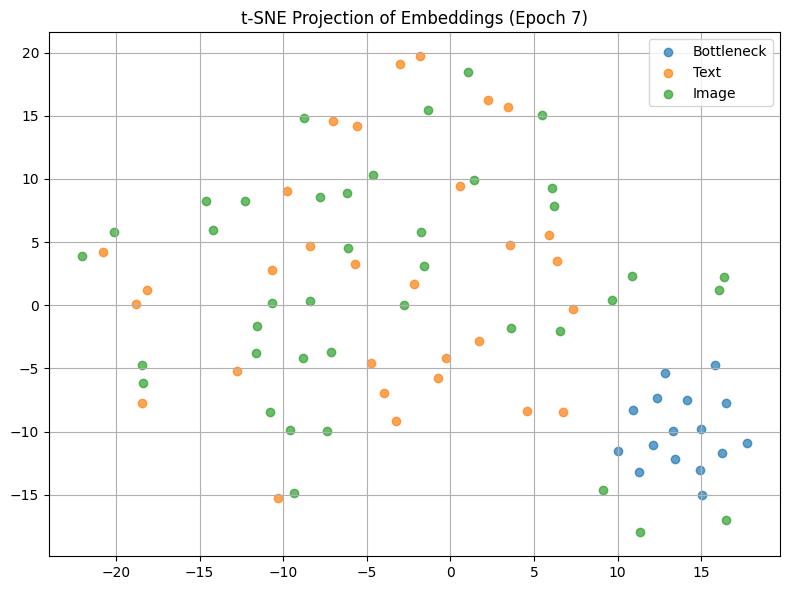

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 8] Loss: 413.3860 | Bottleneck STD: 0.009886 | Mean Similarity: 0.8047 | Div Loss: 0.587858 | Var Loss: 0.000114
Avg max sim to text:  0.1199
Avg max sim to image: 0.0902


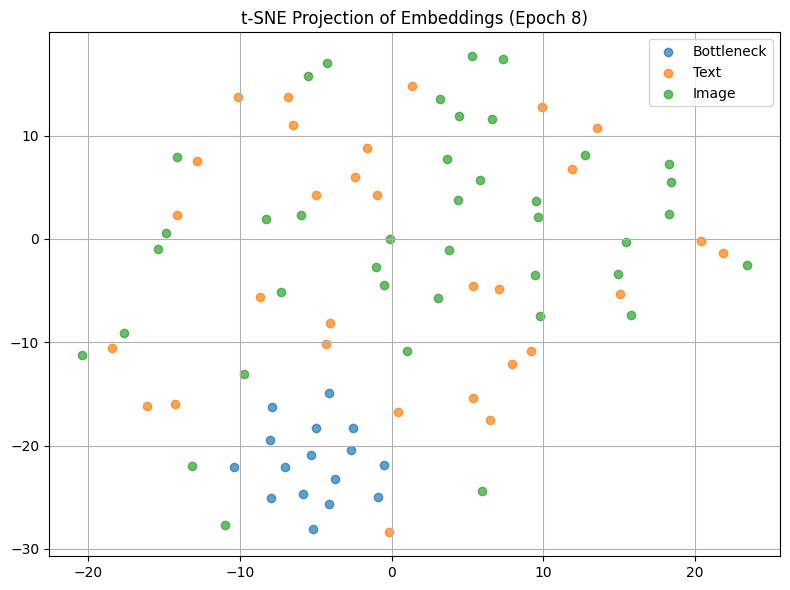

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 9] Loss: 298.6775 | Bottleneck STD: 0.009833 | Mean Similarity: 0.6925 | Div Loss: 0.423872 | Var Loss: 0.000167
Avg max sim to text:  0.0953
Avg max sim to image: 0.1084


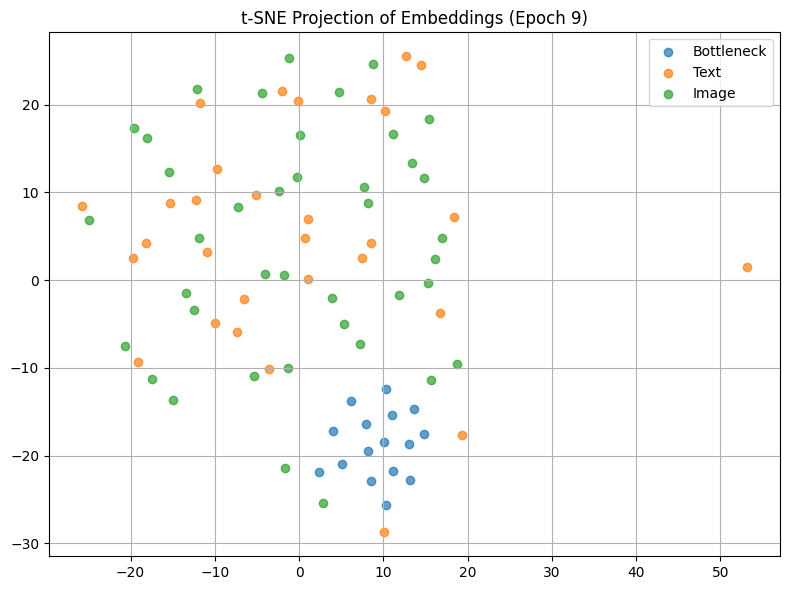

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 10] Loss: 340.8809 | Bottleneck STD: 0.009687 | Mean Similarity: 0.7360 | Div Loss: 0.484081 | Var Loss: 0.000313
Avg max sim to text:  0.0907
Avg max sim to image: 0.1079


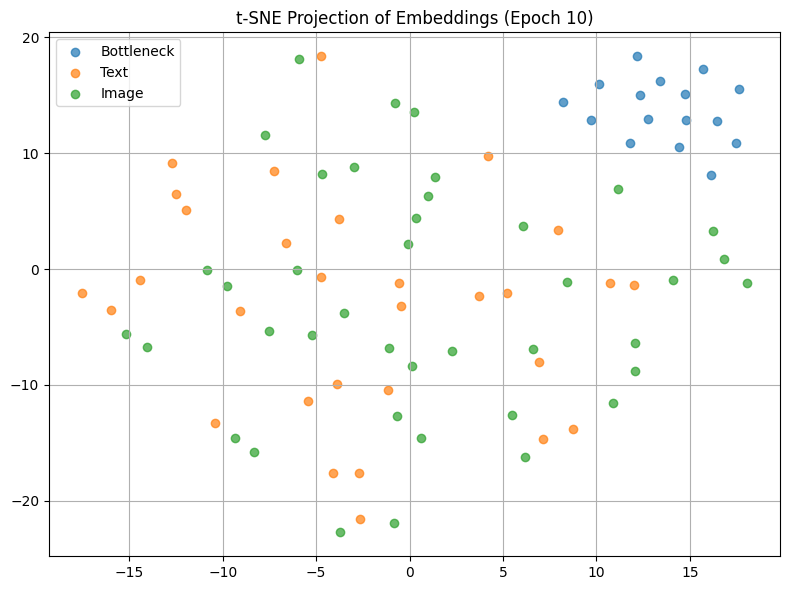

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 11] Loss: 274.9111 | Bottleneck STD: 0.009800 | Mean Similarity: 0.6665 | Div Loss: 0.389746 | Var Loss: 0.000200
Avg max sim to text:  0.0910
Avg max sim to image: 0.0895


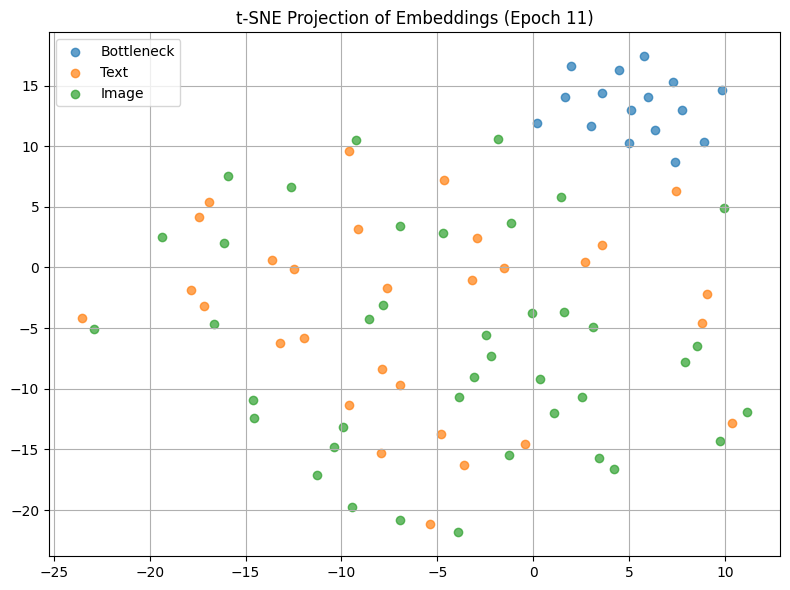

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 12] Loss: 231.8500 | Bottleneck STD: 0.009805 | Mean Similarity: 0.6167 | Div Loss: 0.328296 | Var Loss: 0.000195
Avg max sim to text:  0.1051
Avg max sim to image: 0.1030


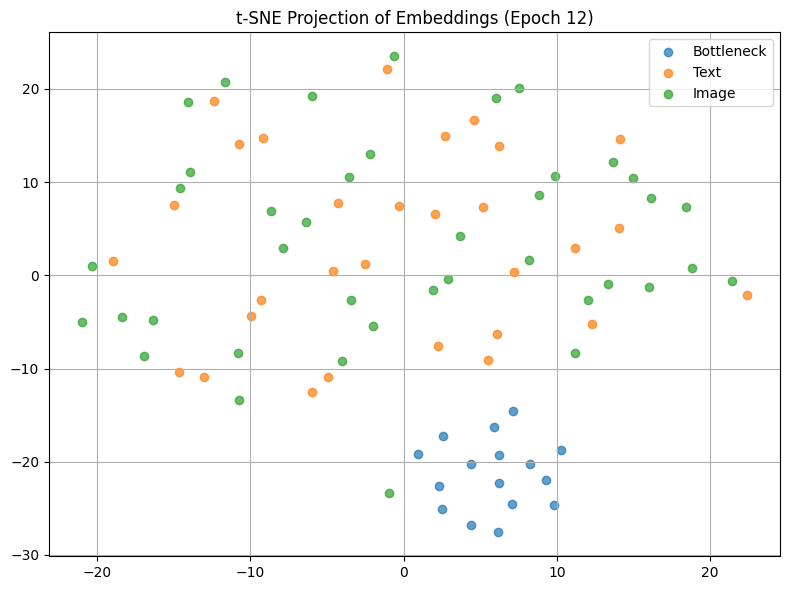

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 13] Loss: 247.1534 | Bottleneck STD: 0.009893 | Mean Similarity: 0.6352 | Div Loss: 0.350328 | Var Loss: 0.000107
Avg max sim to text:  0.0875
Avg max sim to image: 0.1108


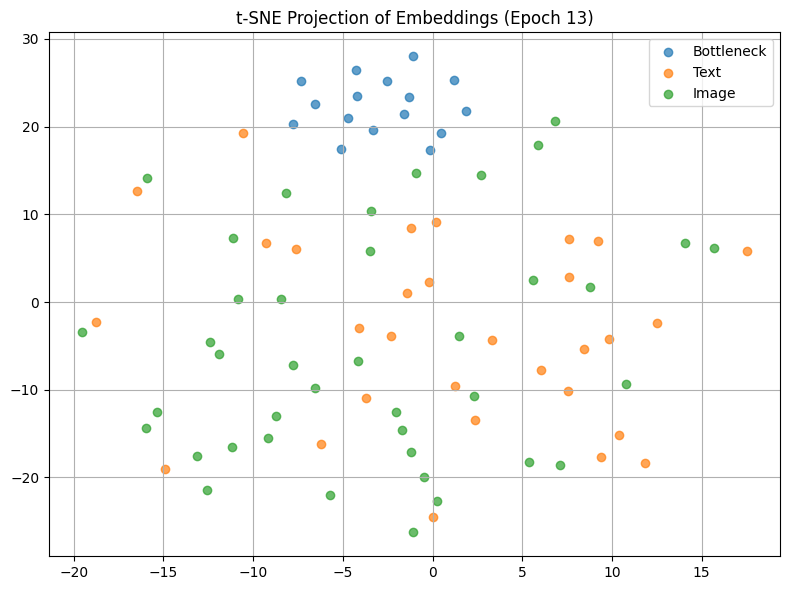

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 14] Loss: 143.4576 | Bottleneck STD: 0.009847 | Mean Similarity: 0.4966 | Div Loss: 0.202033 | Var Loss: 0.000153
Avg max sim to text:  0.0915
Avg max sim to image: 0.0998


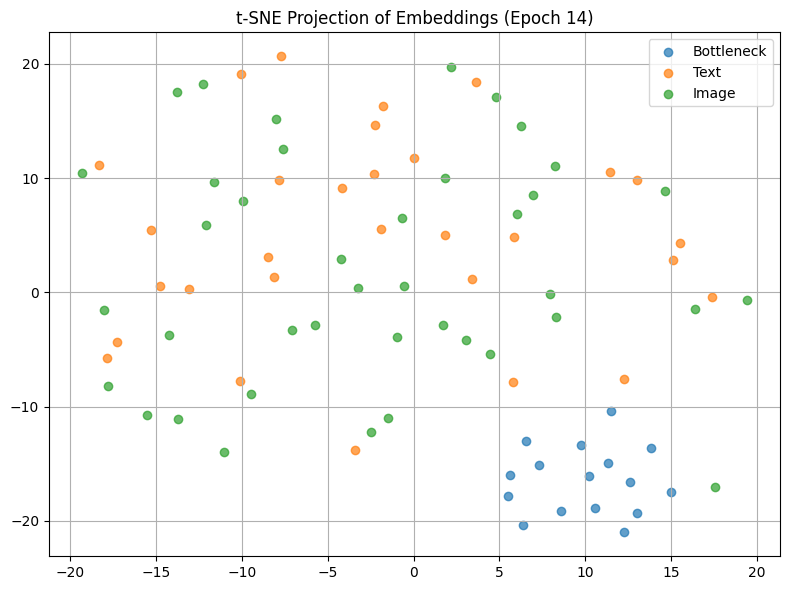

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 15] Loss: 154.8373 | Bottleneck STD: 0.009911 | Mean Similarity: 0.5138 | Div Loss: 0.218373 | Var Loss: 0.000089
Avg max sim to text:  0.1284
Avg max sim to image: 0.1146


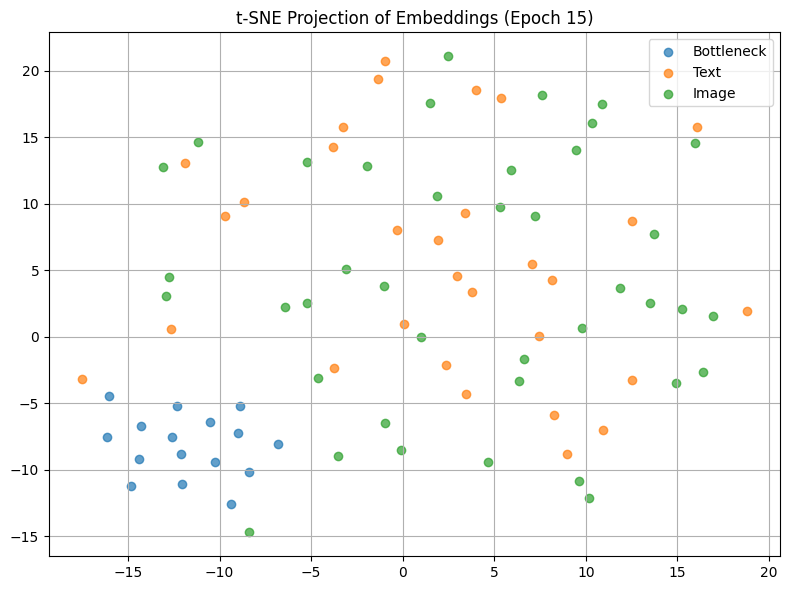

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 16] Loss: 135.7203 | Bottleneck STD: 0.009774 | Mean Similarity: 0.4846 | Div Loss: 0.191027 | Var Loss: 0.000226
Avg max sim to text:  0.1121
Avg max sim to image: 0.1076


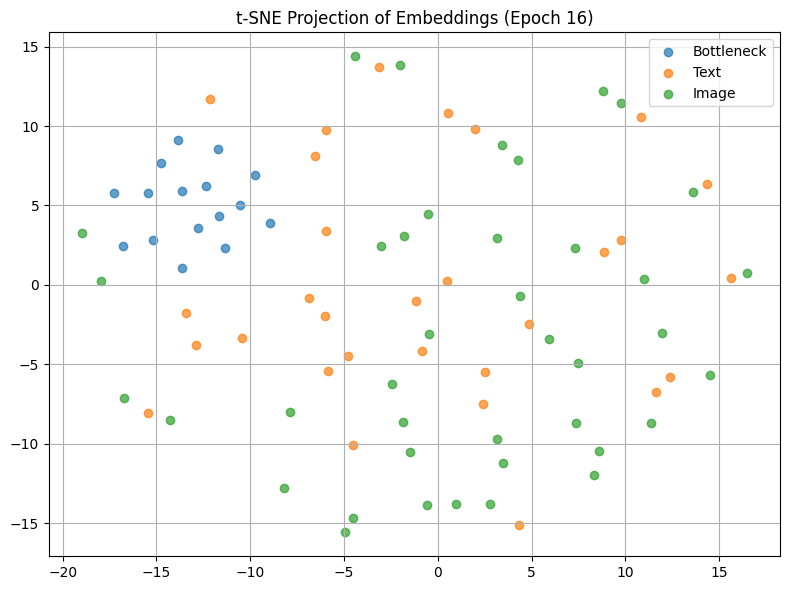

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 17] Loss: 123.3363 | Bottleneck STD: 0.009773 | Mean Similarity: 0.4646 | Div Loss: 0.173460 | Var Loss: 0.000227
Avg max sim to text:  0.0960
Avg max sim to image: 0.1070


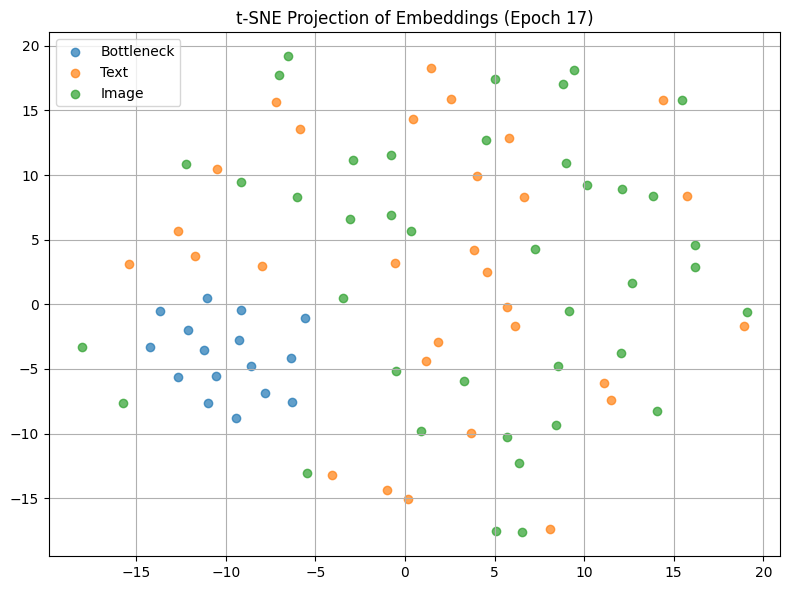

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 18] Loss: 69.9848 | Bottleneck STD: 0.009896 | Mean Similarity: 0.3612 | Div Loss: 0.097183 | Var Loss: 0.000104
Avg max sim to text:  0.1141
Avg max sim to image: 0.0976


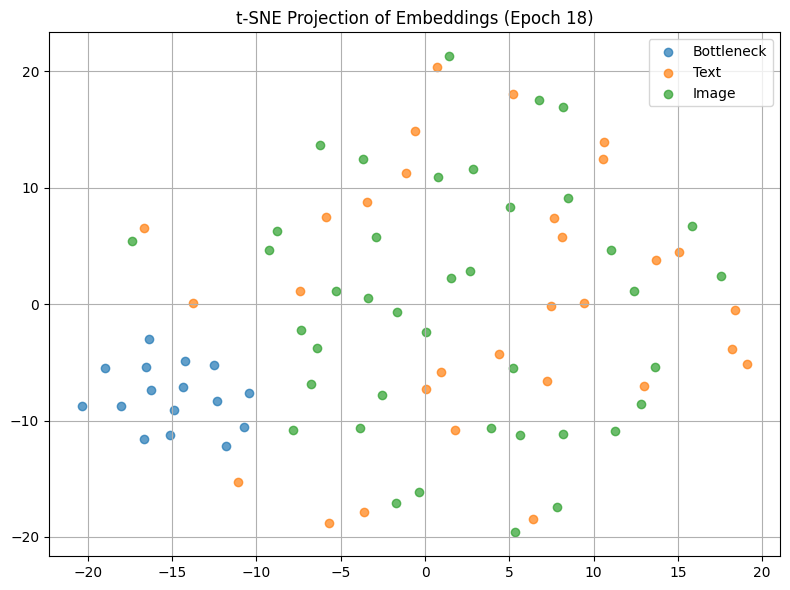

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 19] Loss: 70.5490 | Bottleneck STD: 0.009924 | Mean Similarity: 0.3627 | Div Loss: 0.097899 | Var Loss: 0.000076
Avg max sim to text:  0.1029
Avg max sim to image: 0.1095


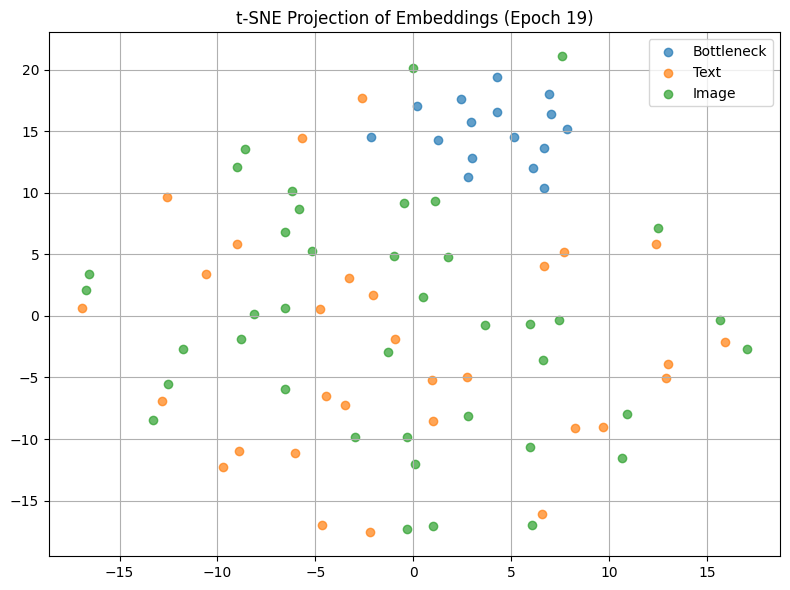

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 20] Loss: 64.4539 | Bottleneck STD: 0.009746 | Mean Similarity: 0.3495 | Div Loss: 0.089271 | Var Loss: 0.000254
Avg max sim to text:  0.1094
Avg max sim to image: 0.1240


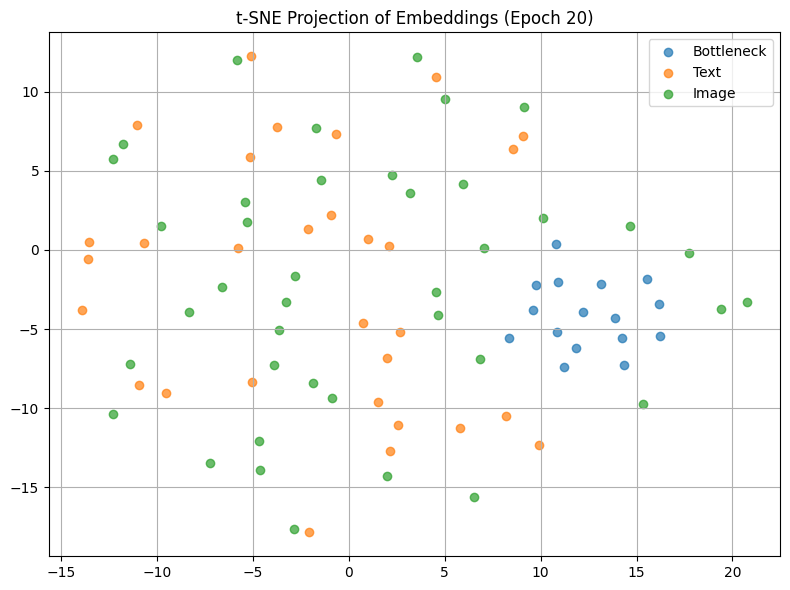

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 21] Loss: 64.4873 | Bottleneck STD: 0.009895 | Mean Similarity: 0.3485 | Div Loss: 0.089240 | Var Loss: 0.000105
Avg max sim to text:  0.1067
Avg max sim to image: 0.1056


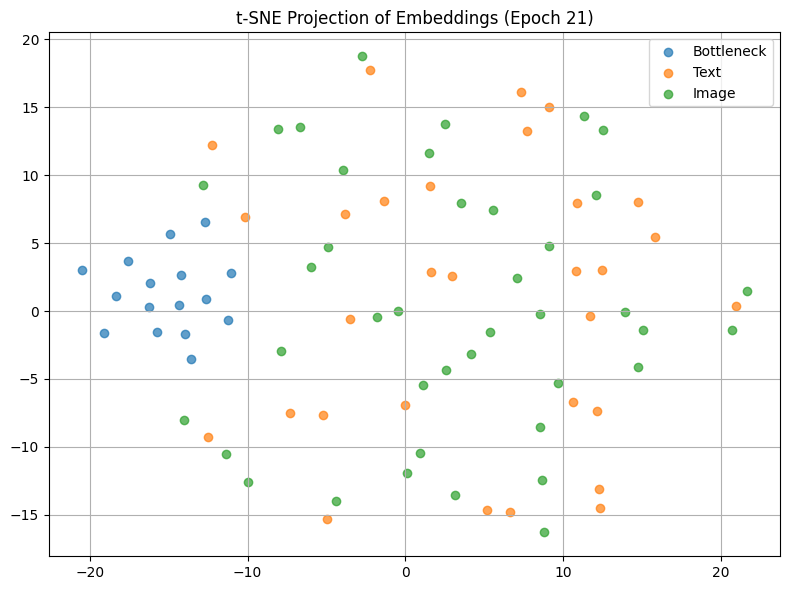

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 22] Loss: 45.0117 | Bottleneck STD: 0.010126 | Mean Similarity: 0.2990 | Div Loss: 0.061470 | Var Loss: 0.000000
Avg max sim to text:  0.1167
Avg max sim to image: 0.1036


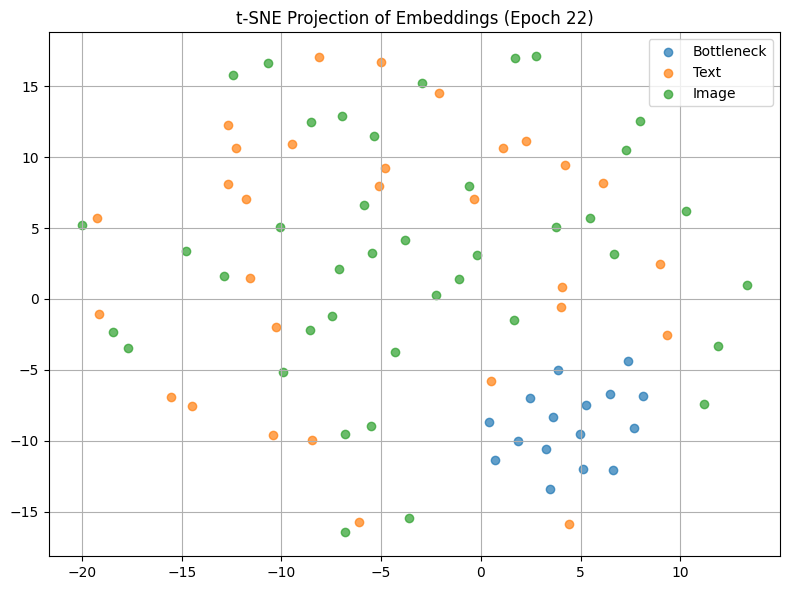

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 23] Loss: 36.9593 | Bottleneck STD: 0.009961 | Mean Similarity: 0.2745 | Div Loss: 0.049898 | Var Loss: 0.000039
Avg max sim to text:  0.0968
Avg max sim to image: 0.1159


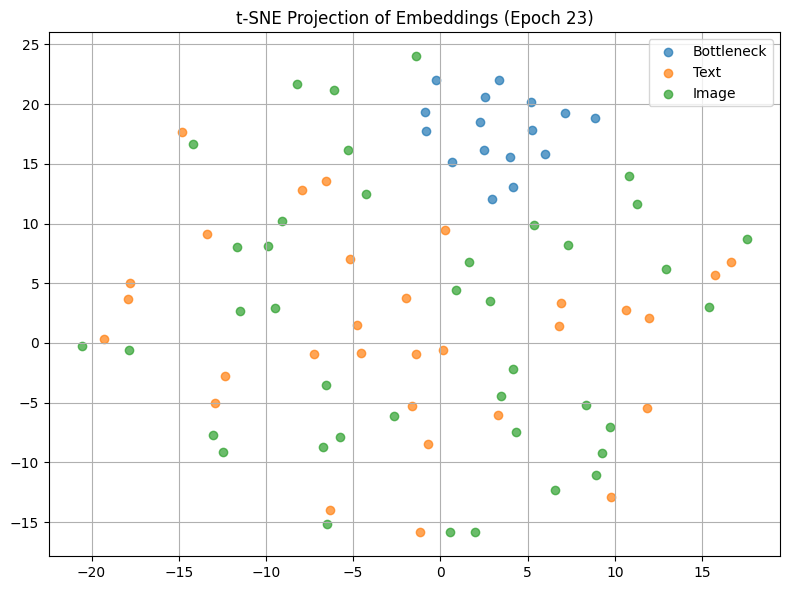

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 24] Loss: 40.8115 | Bottleneck STD: 0.009934 | Mean Similarity: 0.2865 | Div Loss: 0.055265 | Var Loss: 0.000066
Avg max sim to text:  0.0897
Avg max sim to image: 0.1064


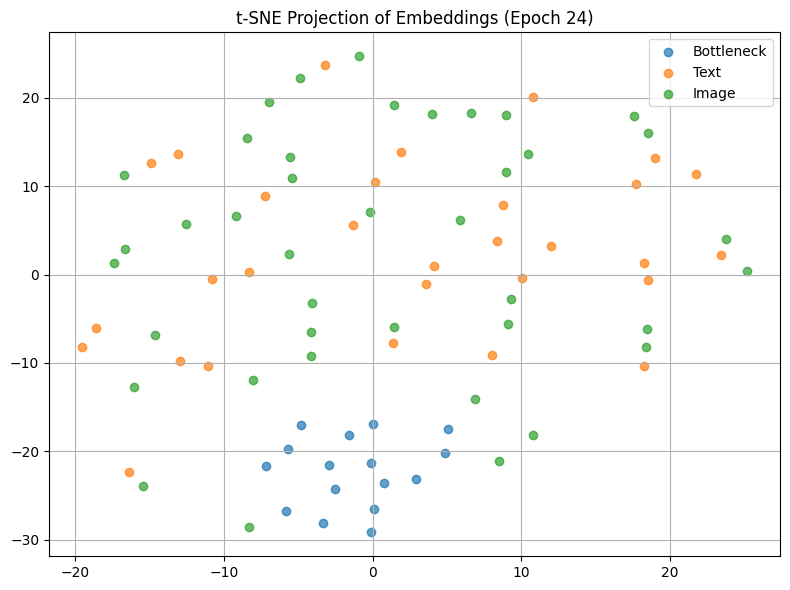

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 25] Loss: 38.8550 | Bottleneck STD: 0.009881 | Mean Similarity: 0.2803 | Div Loss: 0.052488 | Var Loss: 0.000119
Avg max sim to text:  0.0969
Avg max sim to image: 0.1122


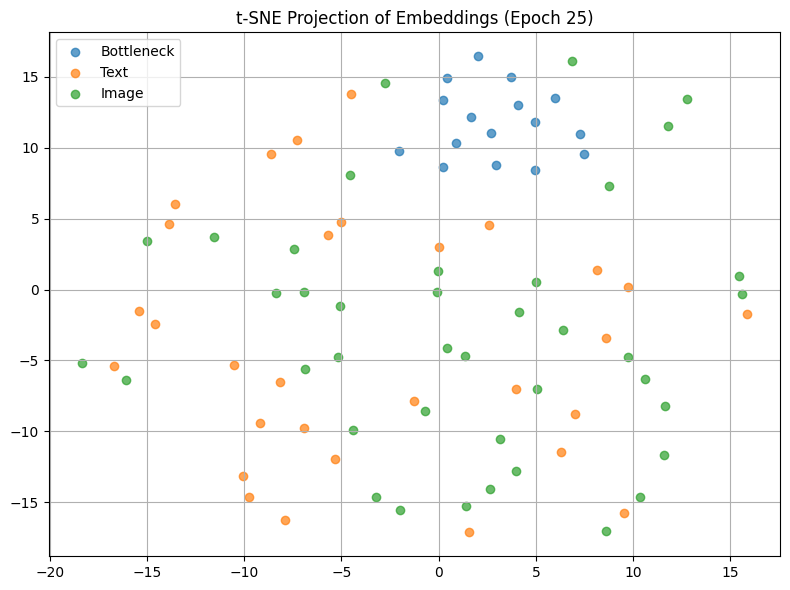

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 26] Loss: 31.6312 | Bottleneck STD: 0.009927 | Mean Similarity: 0.2576 | Div Loss: 0.042407 | Var Loss: 0.000073
Avg max sim to text:  0.1105
Avg max sim to image: 0.1023


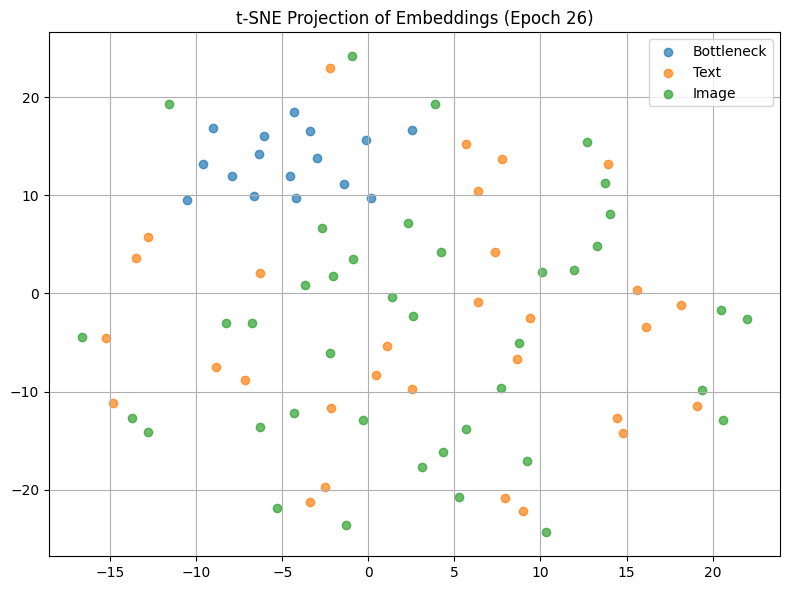

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 27] Loss: 39.3011 | Bottleneck STD: 0.009796 | Mean Similarity: 0.2822 | Div Loss: 0.053449 | Var Loss: 0.000204
Avg max sim to text:  0.1096
Avg max sim to image: 0.1157


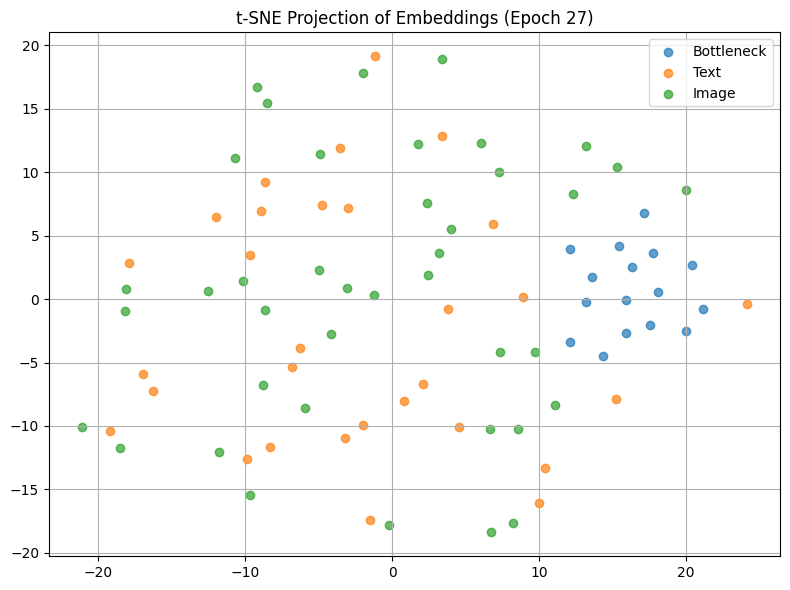

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 28] Loss: 24.3876 | Bottleneck STD: 0.009753 | Mean Similarity: 0.2302 | Div Loss: 0.032085 | Var Loss: 0.000247
Avg max sim to text:  0.1220
Avg max sim to image: 0.1198


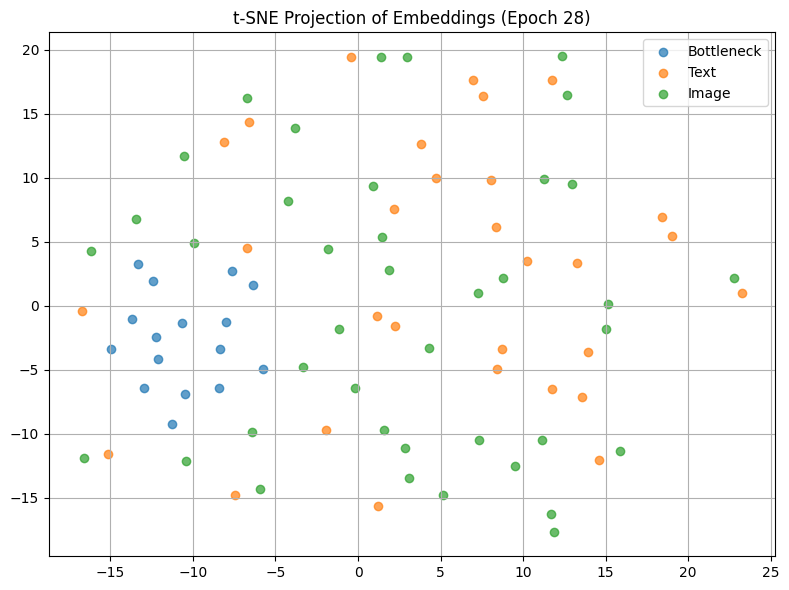

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 29] Loss: 28.6855 | Bottleneck STD: 0.009837 | Mean Similarity: 0.2467 | Div Loss: 0.038134 | Var Loss: 0.000163
Avg max sim to text:  0.1025
Avg max sim to image: 0.0980


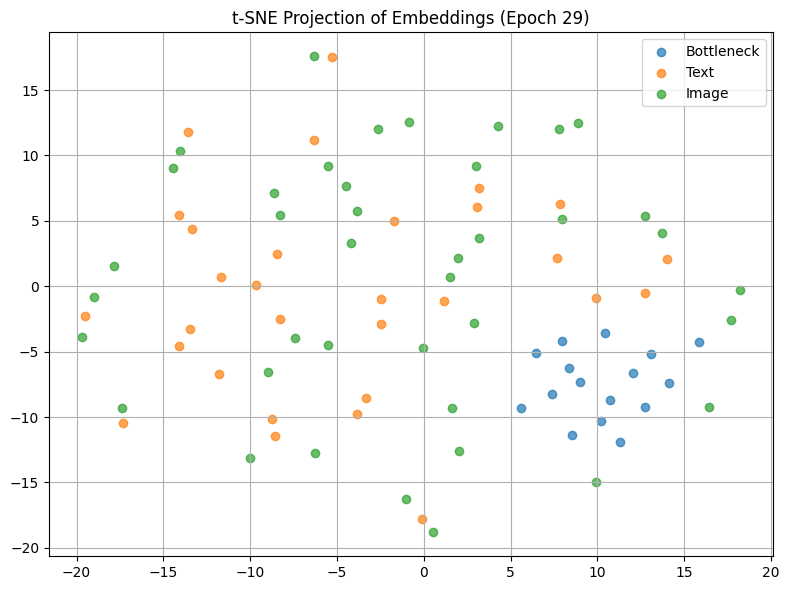

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 30] Loss: 20.0668 | Bottleneck STD: 0.009949 | Mean Similarity: 0.2115 | Div Loss: 0.025816 | Var Loss: 0.000051
Avg max sim to text:  0.1163
Avg max sim to image: 0.0982


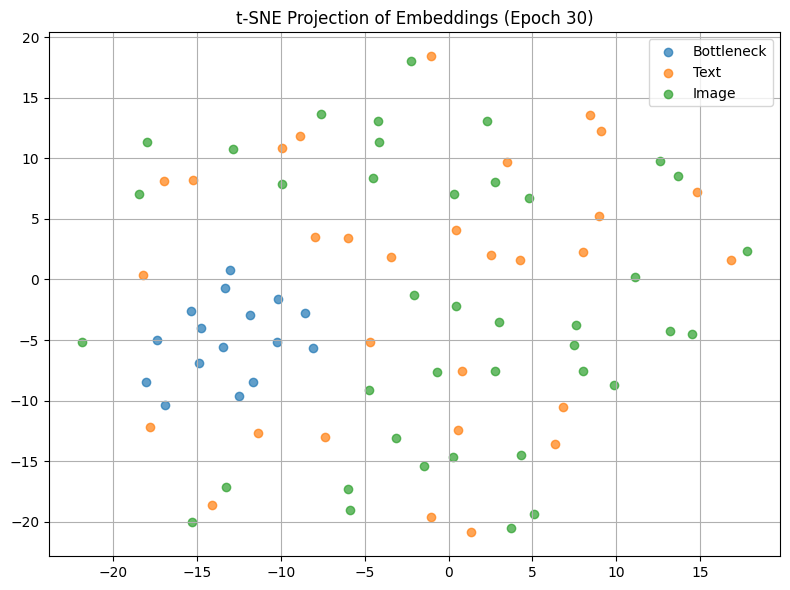

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 31] Loss: 25.3505 | Bottleneck STD: 0.010011 | Mean Similarity: 0.2330 | Div Loss: 0.033465 | Var Loss: 0.000000
Avg max sim to text:  0.1034
Avg max sim to image: 0.1145


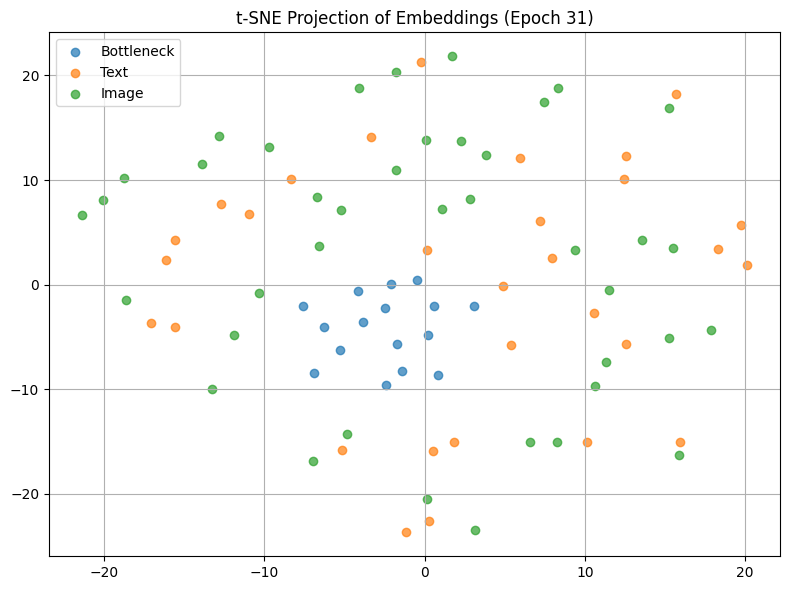

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 32] Loss: 26.7503 | Bottleneck STD: 0.009726 | Mean Similarity: 0.2402 | Div Loss: 0.035536 | Var Loss: 0.000274
Avg max sim to text:  0.1187
Avg max sim to image: 0.1145


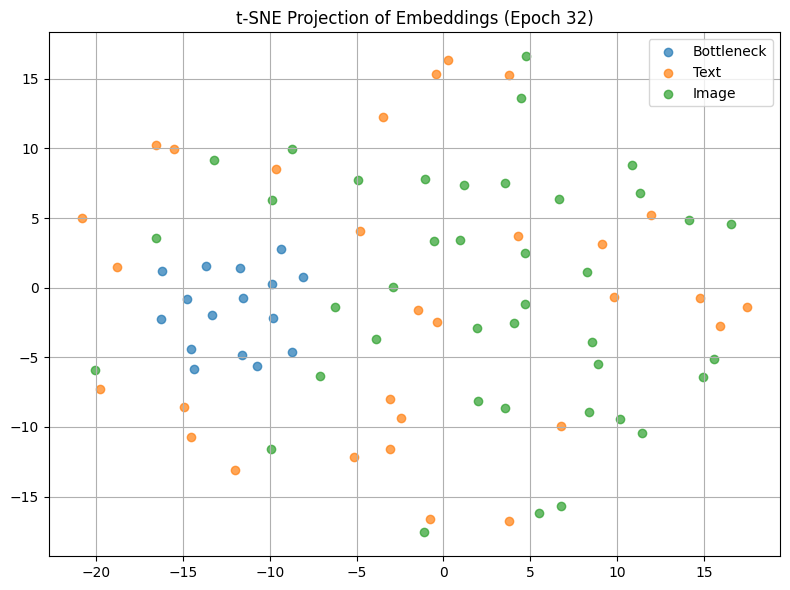

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 33] Loss: 20.7221 | Bottleneck STD: 0.009848 | Mean Similarity: 0.2158 | Div Loss: 0.026798 | Var Loss: 0.000152
Avg max sim to text:  0.1154
Avg max sim to image: 0.1063


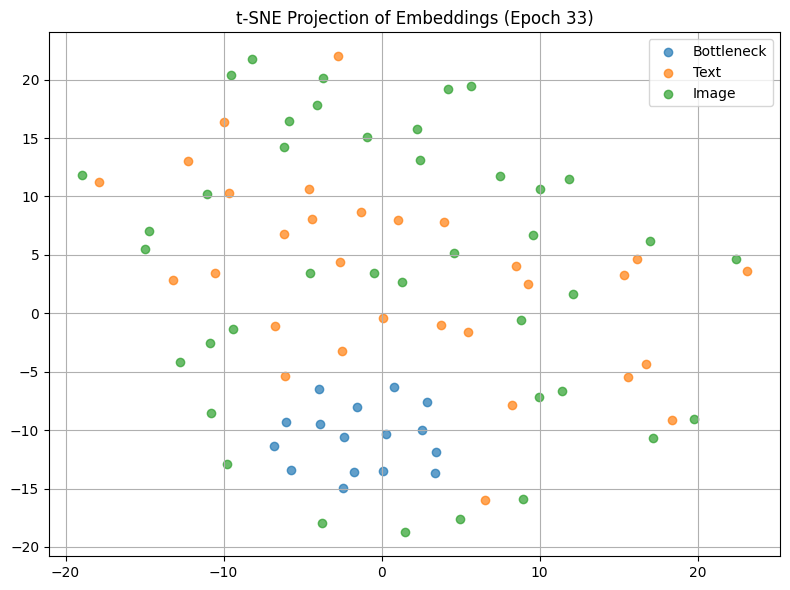

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 34] Loss: 21.1313 | Bottleneck STD: 0.009834 | Mean Similarity: 0.2161 | Div Loss: 0.027220 | Var Loss: 0.000166
Avg max sim to text:  0.0981
Avg max sim to image: 0.1053


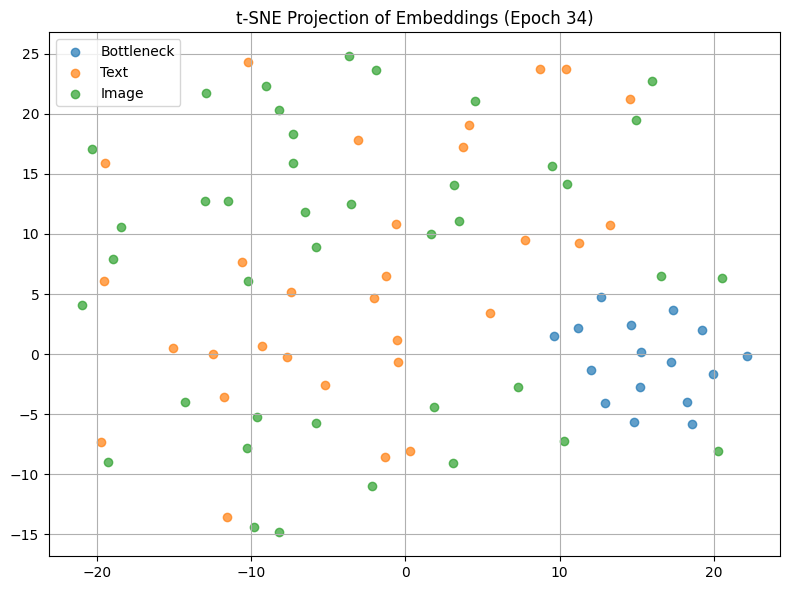

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 35] Loss: 21.6115 | Bottleneck STD: 0.010029 | Mean Similarity: 0.2185 | Div Loss: 0.027873 | Var Loss: 0.000000
Avg max sim to text:  0.0798
Avg max sim to image: 0.1200


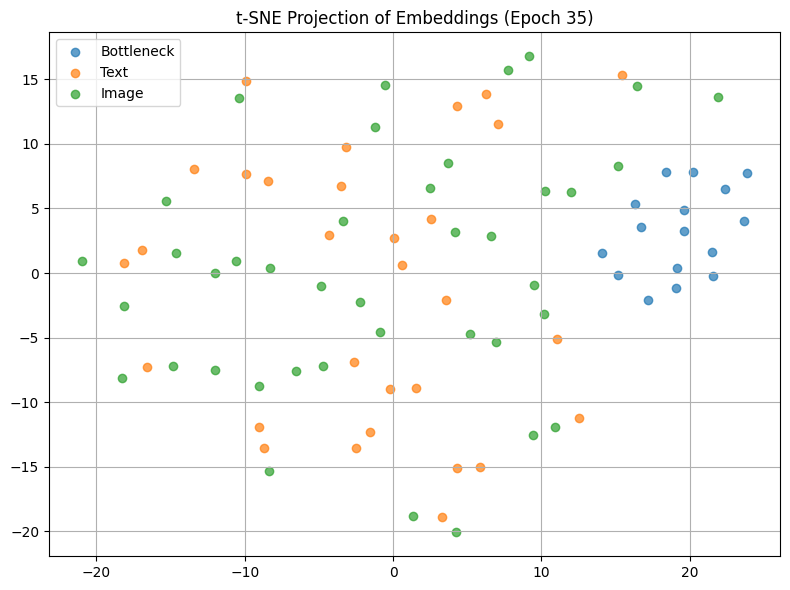

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 36] Loss: 22.1713 | Bottleneck STD: 0.009738 | Mean Similarity: 0.2221 | Div Loss: 0.028879 | Var Loss: 0.000262
Avg max sim to text:  0.1017
Avg max sim to image: 0.1078


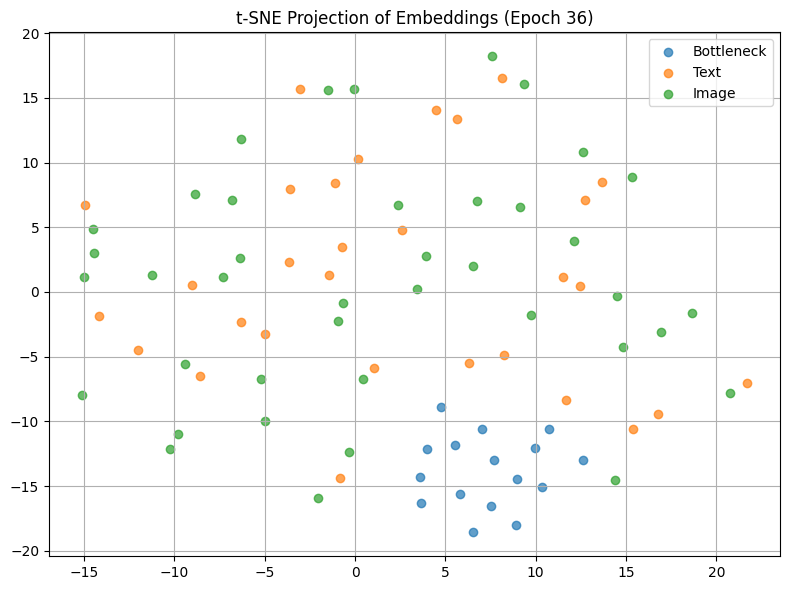

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 37] Loss: 15.0838 | Bottleneck STD: 0.009929 | Mean Similarity: 0.1857 | Div Loss: 0.018789 | Var Loss: 0.000071
Avg max sim to text:  0.1013
Avg max sim to image: 0.1096


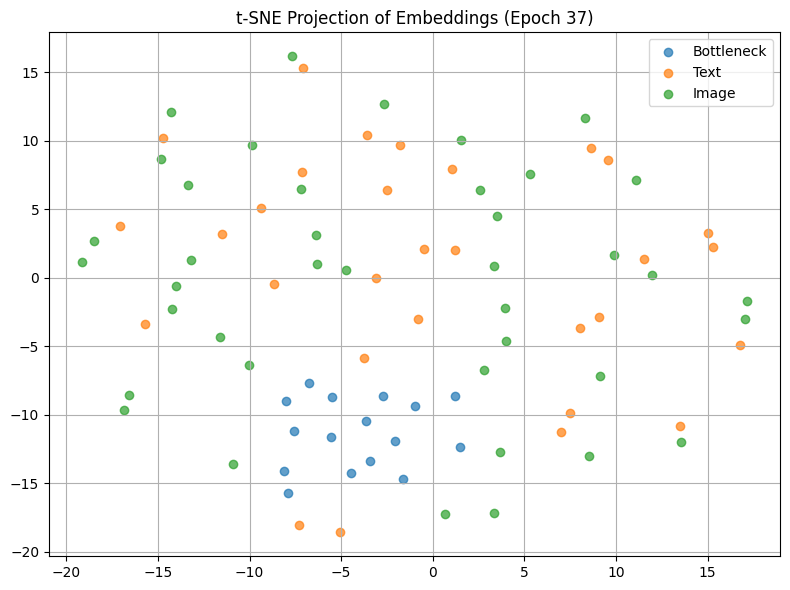

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 38] Loss: 23.3379 | Bottleneck STD: 0.009743 | Mean Similarity: 0.2268 | Div Loss: 0.030458 | Var Loss: 0.000257
Avg max sim to text:  0.1125
Avg max sim to image: 0.1037


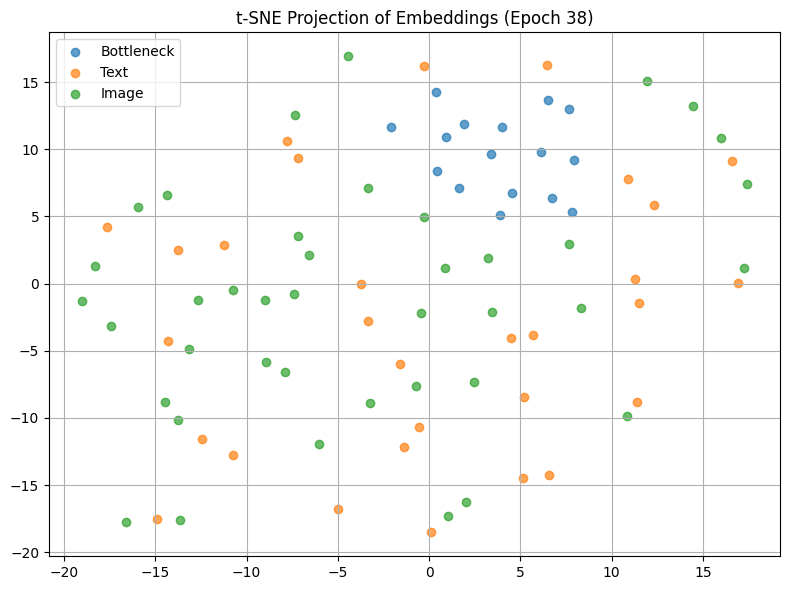

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 39] Loss: 15.1232 | Bottleneck STD: 0.009767 | Mean Similarity: 0.1896 | Div Loss: 0.018925 | Var Loss: 0.000233
Avg max sim to text:  0.1163
Avg max sim to image: 0.1104


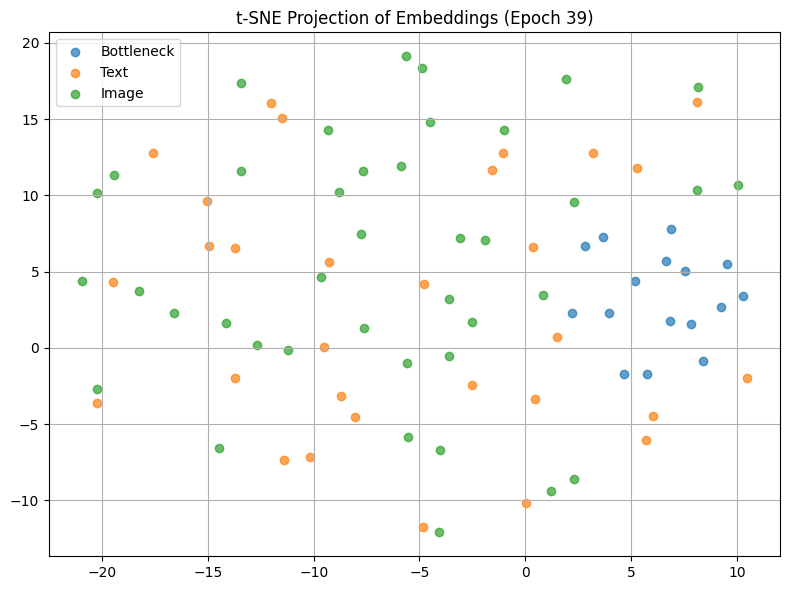

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 40] Loss: 17.6517 | Bottleneck STD: 0.009960 | Mean Similarity: 0.2018 | Div Loss: 0.022496 | Var Loss: 0.000040
Avg max sim to text:  0.1054
Avg max sim to image: 0.1061


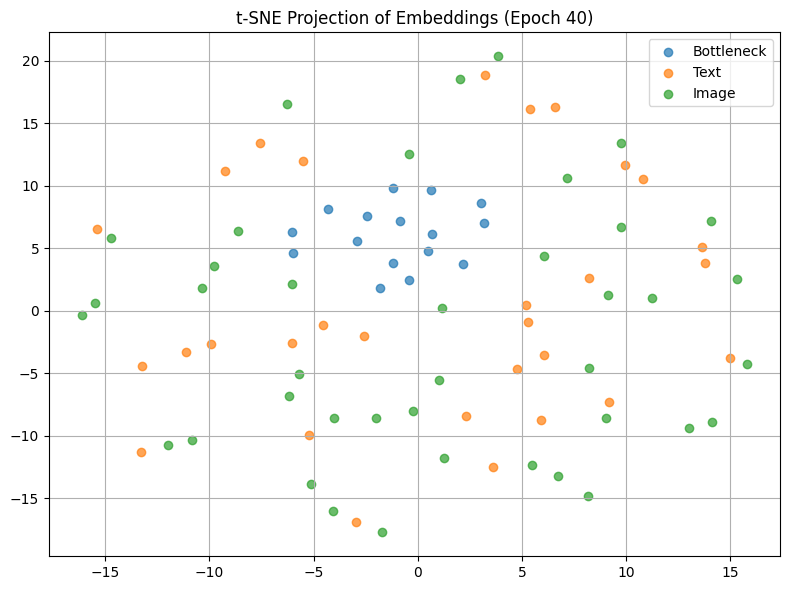

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 41] Loss: 19.7031 | Bottleneck STD: 0.009657 | Mean Similarity: 0.2107 | Div Loss: 0.025363 | Var Loss: 0.000343
Avg max sim to text:  0.1000
Avg max sim to image: 0.1163


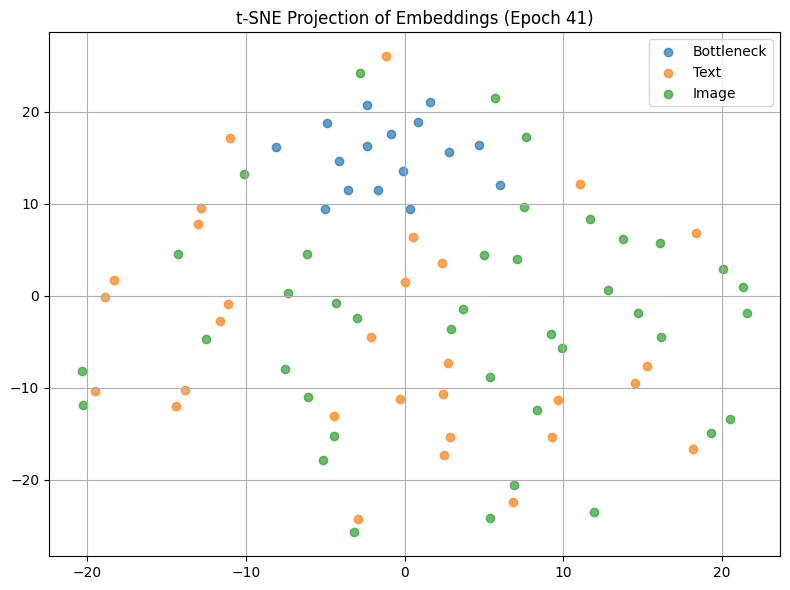

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 42] Loss: 19.2999 | Bottleneck STD: 0.009878 | Mean Similarity: 0.2073 | Div Loss: 0.024571 | Var Loss: 0.000122
Avg max sim to text:  0.1110
Avg max sim to image: 0.1004


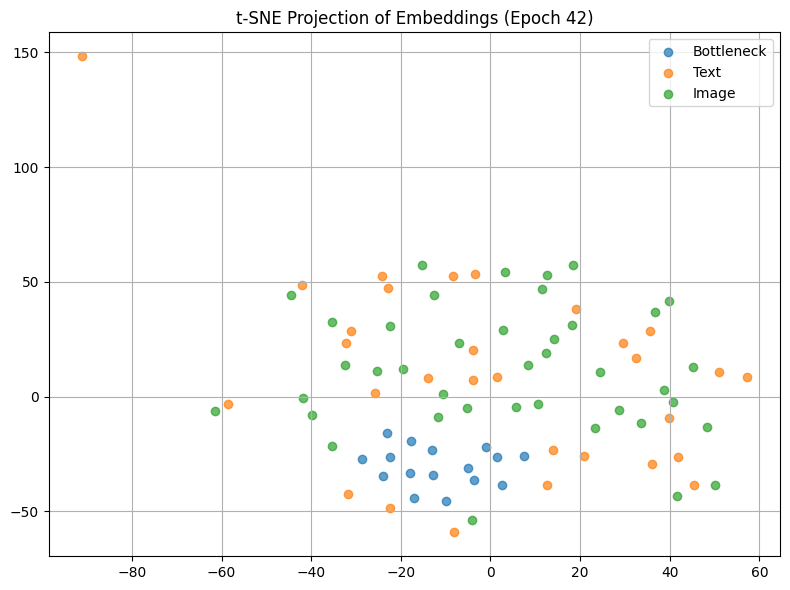

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 43] Loss: 14.5247 | Bottleneck STD: 0.009906 | Mean Similarity: 0.1840 | Div Loss: 0.017821 | Var Loss: 0.000094
Avg max sim to text:  0.0978
Avg max sim to image: 0.1134


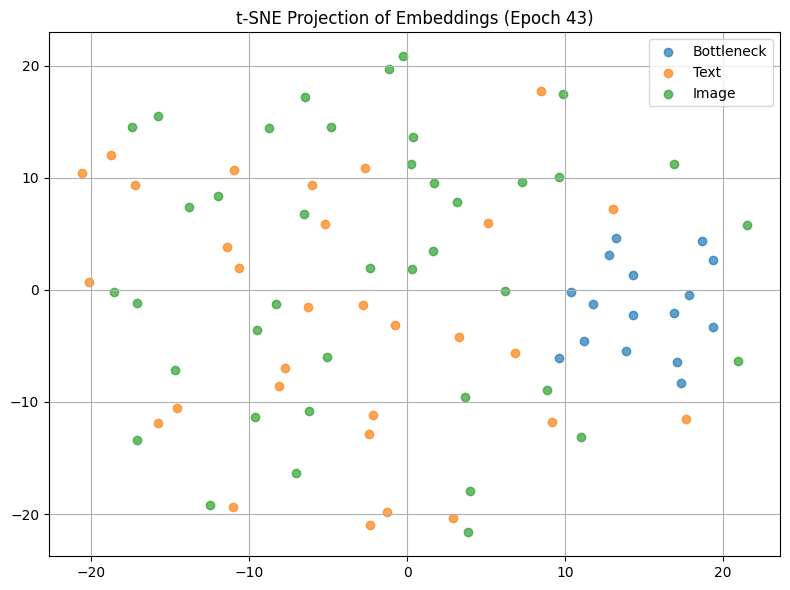

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 44] Loss: 16.1249 | Bottleneck STD: 0.009979 | Mean Similarity: 0.1906 | Div Loss: 0.020114 | Var Loss: 0.000021
Avg max sim to text:  0.0970
Avg max sim to image: 0.1085


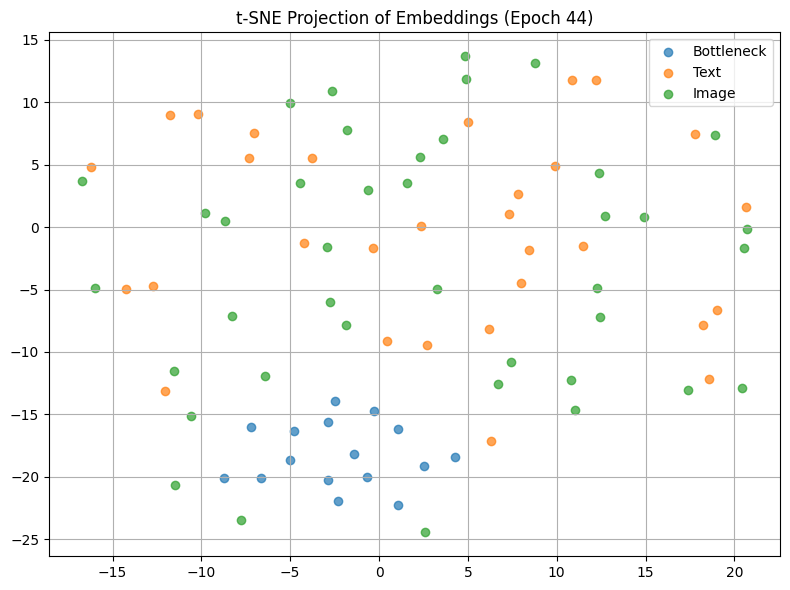

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 45] Loss: 12.4607 | Bottleneck STD: 0.009733 | Mean Similarity: 0.1725 | Div Loss: 0.014746 | Var Loss: 0.000267
Avg max sim to text:  0.0969
Avg max sim to image: 0.1153


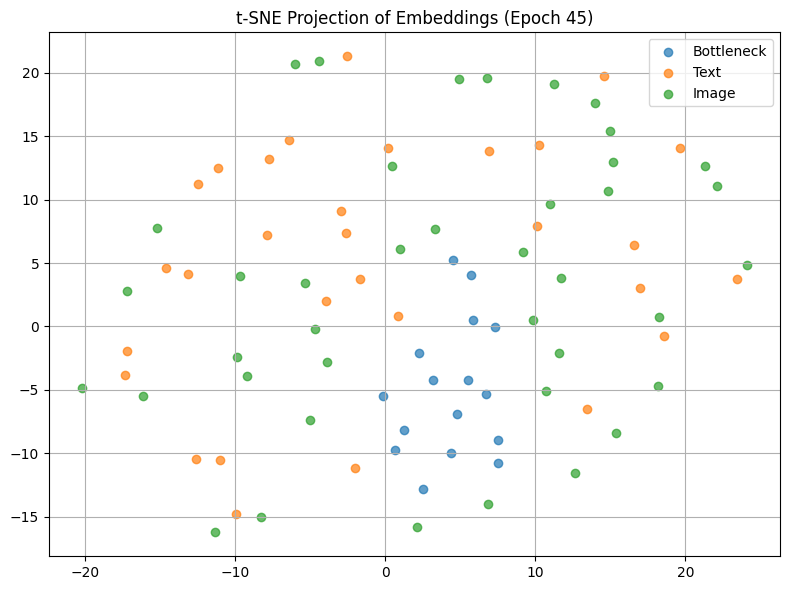

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 46] Loss: 17.6191 | Bottleneck STD: 0.009676 | Mean Similarity: 0.1991 | Div Loss: 0.022467 | Var Loss: 0.000324
Avg max sim to text:  0.1091
Avg max sim to image: 0.1206


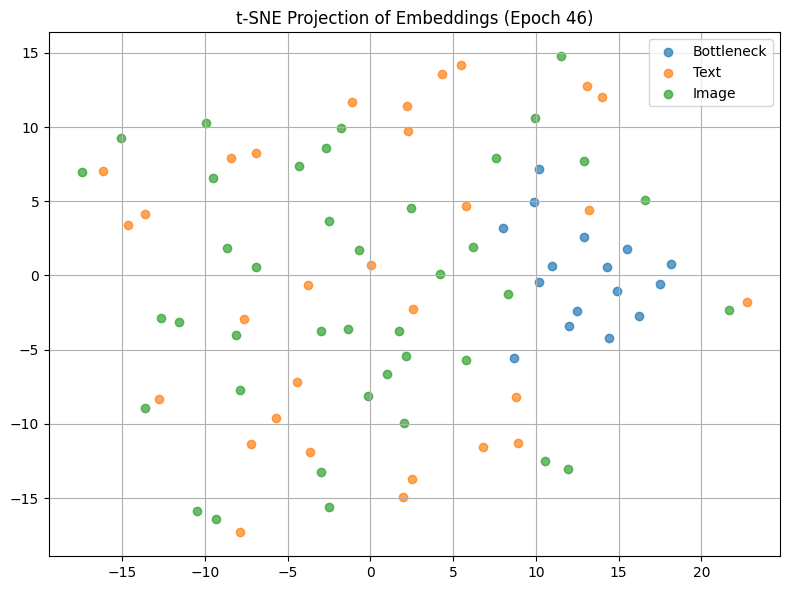

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 47] Loss: 14.6532 | Bottleneck STD: 0.009970 | Mean Similarity: 0.1850 | Div Loss: 0.018243 | Var Loss: 0.000030
Avg max sim to text:  0.1124
Avg max sim to image: 0.1208


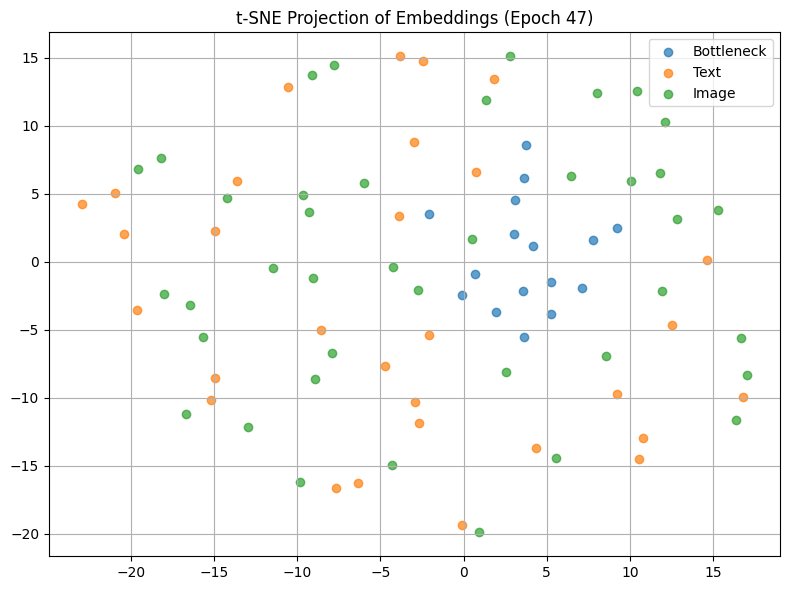

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 48] Loss: 15.9952 | Bottleneck STD: 0.009934 | Mean Similarity: 0.1924 | Div Loss: 0.020352 | Var Loss: 0.000066
Avg max sim to text:  0.1141
Avg max sim to image: 0.1315


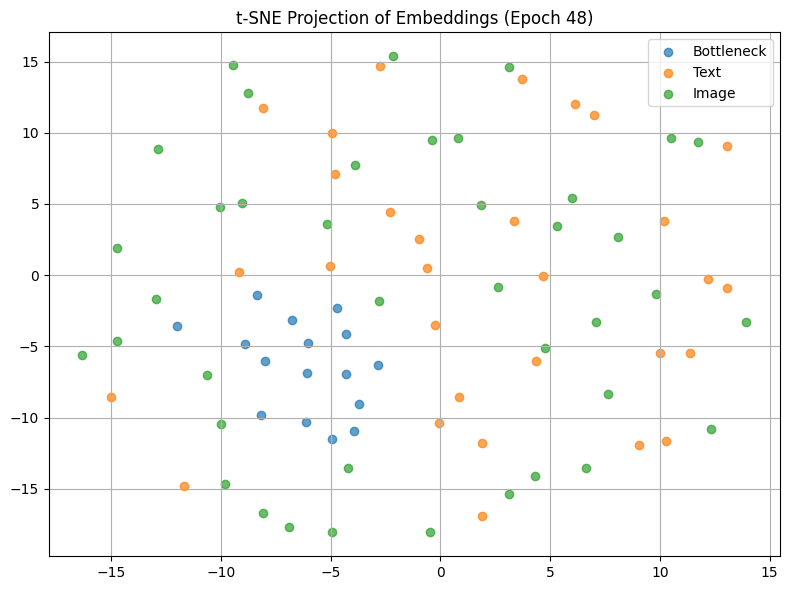

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 49] Loss: 13.6311 | Bottleneck STD: 0.009666 | Mean Similarity: 0.1778 | Div Loss: 0.016792 | Var Loss: 0.000334
Avg max sim to text:  0.1050
Avg max sim to image: 0.1159


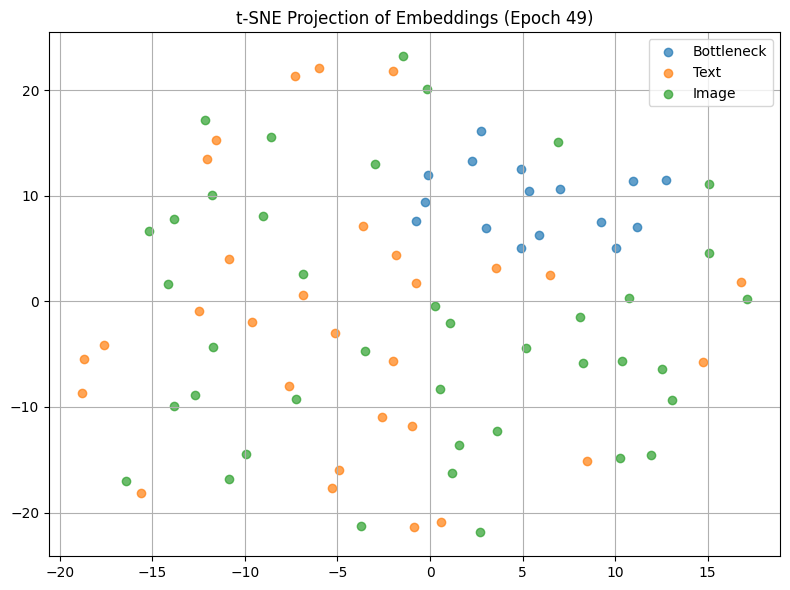

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 50] Loss: 16.5646 | Bottleneck STD: 0.009874 | Mean Similarity: 0.1932 | Div Loss: 0.020706 | Var Loss: 0.000126
Avg max sim to text:  0.0990
Avg max sim to image: 0.1249


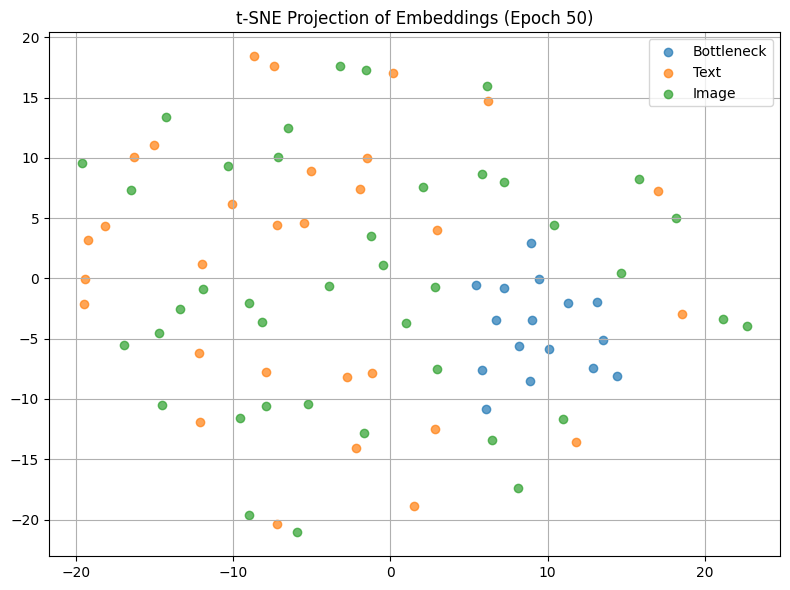

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 51] Loss: 12.3018 | Bottleneck STD: 0.009800 | Mean Similarity: 0.1696 | Div Loss: 0.014502 | Var Loss: 0.000200
Avg max sim to text:  0.1005
Avg max sim to image: 0.1019


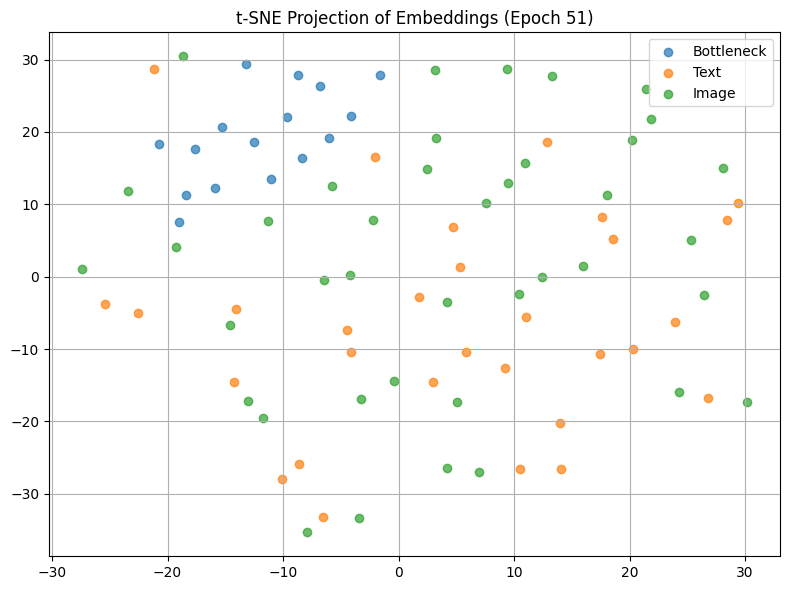

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 52] Loss: 13.0426 | Bottleneck STD: 0.009906 | Mean Similarity: 0.1756 | Div Loss: 0.015686 | Var Loss: 0.000094
Avg max sim to text:  0.1092
Avg max sim to image: 0.1069


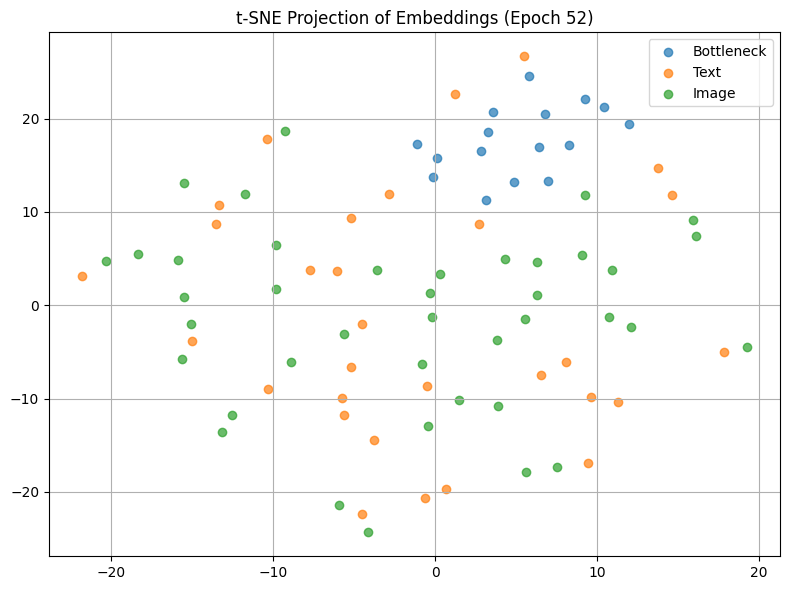

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 53] Loss: 17.0919 | Bottleneck STD: 0.009726 | Mean Similarity: 0.1989 | Div Loss: 0.021913 | Var Loss: 0.000274
Avg max sim to text:  0.1141
Avg max sim to image: 0.1137


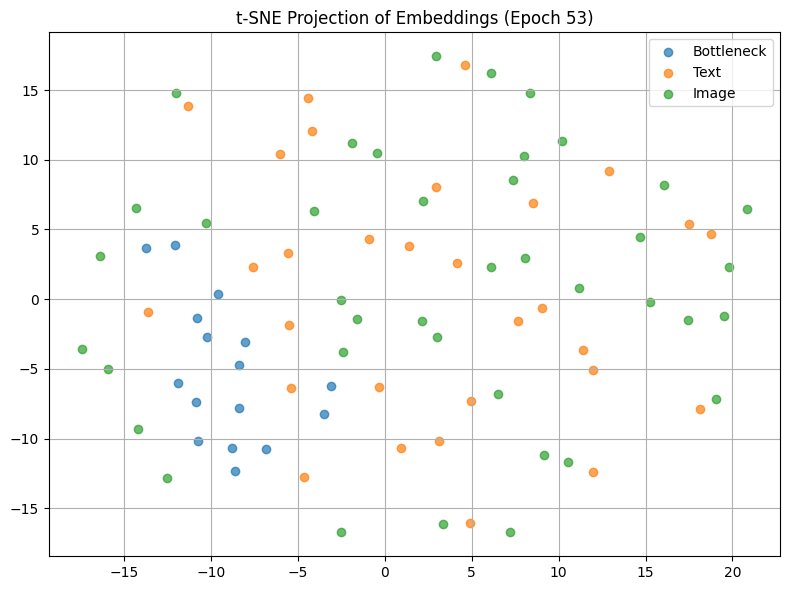

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 54] Loss: 12.0591 | Bottleneck STD: 0.009811 | Mean Similarity: 0.1689 | Div Loss: 0.014521 | Var Loss: 0.000189
Avg max sim to text:  0.1083
Avg max sim to image: 0.1049


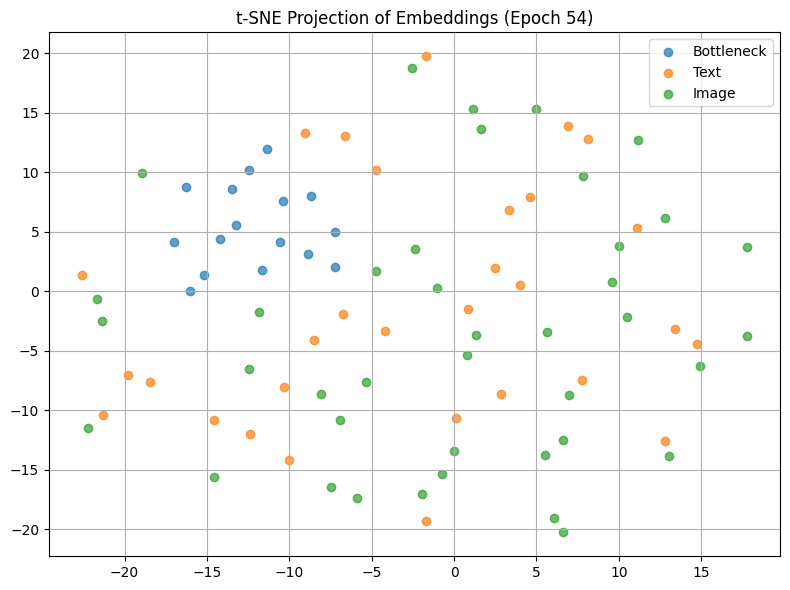

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 55] Loss: 18.5446 | Bottleneck STD: 0.009965 | Mean Similarity: 0.2045 | Div Loss: 0.023626 | Var Loss: 0.000035
Avg max sim to text:  0.1151
Avg max sim to image: 0.1044


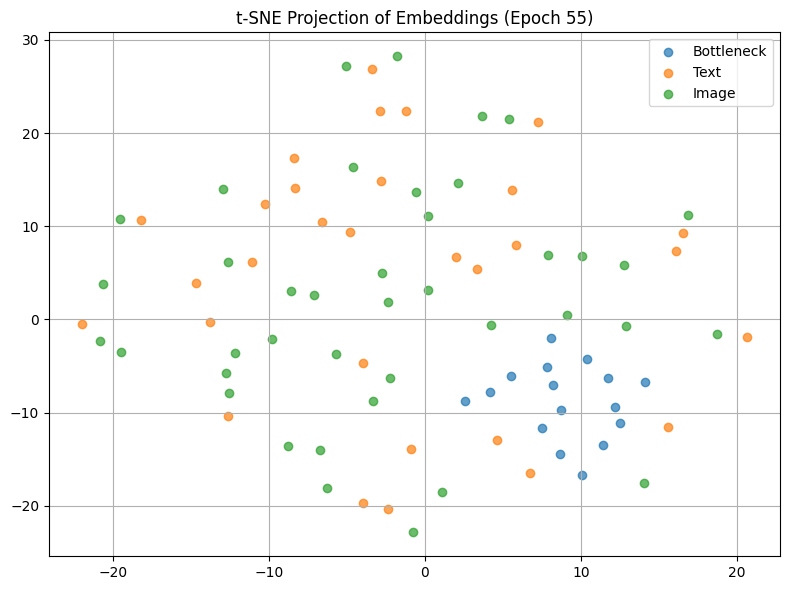

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 56] Loss: 8.9146 | Bottleneck STD: 0.009878 | Mean Similarity: 0.1456 | Div Loss: 0.009859 | Var Loss: 0.000122
Avg max sim to text:  0.1056
Avg max sim to image: 0.1020


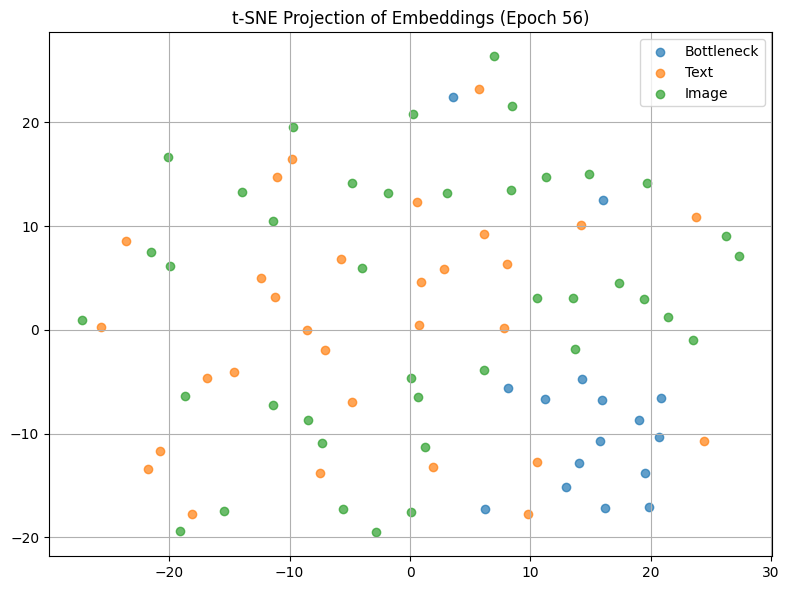

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 57] Loss: 13.3562 | Bottleneck STD: 0.009788 | Mean Similarity: 0.1774 | Div Loss: 0.016275 | Var Loss: 0.000212
Avg max sim to text:  0.1025
Avg max sim to image: 0.1073


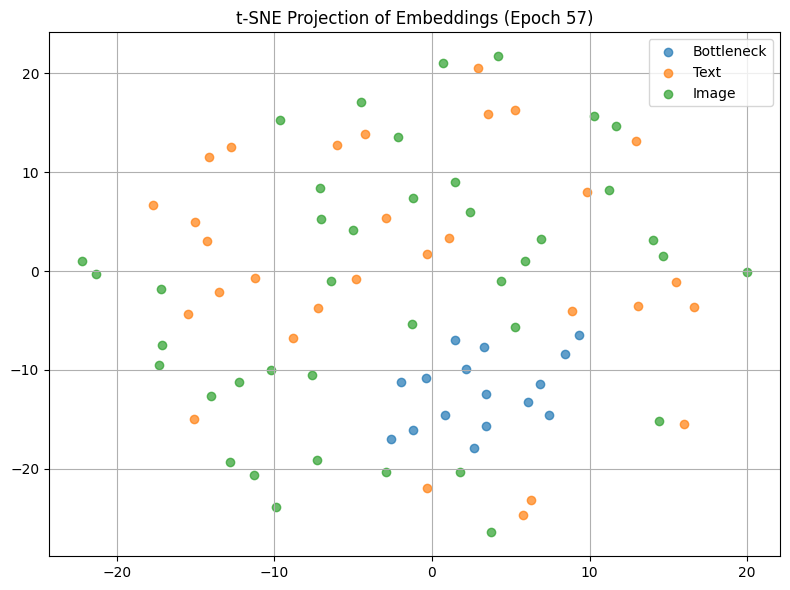

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 58] Loss: 15.2989 | Bottleneck STD: 0.009846 | Mean Similarity: 0.1897 | Div Loss: 0.019061 | Var Loss: 0.000154
Avg max sim to text:  0.0910
Avg max sim to image: 0.1071


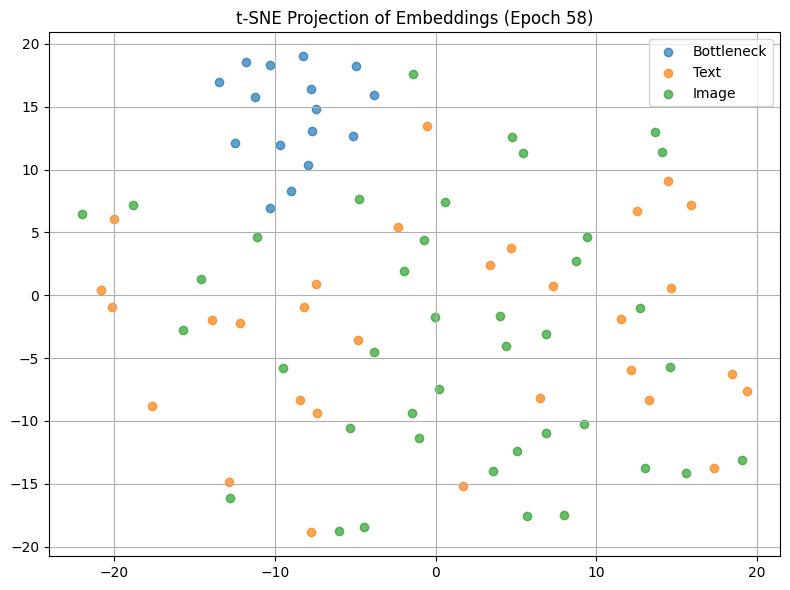

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 59] Loss: 13.1198 | Bottleneck STD: 0.009831 | Mean Similarity: 0.1738 | Div Loss: 0.016047 | Var Loss: 0.000169
Avg max sim to text:  0.1069
Avg max sim to image: 0.1176


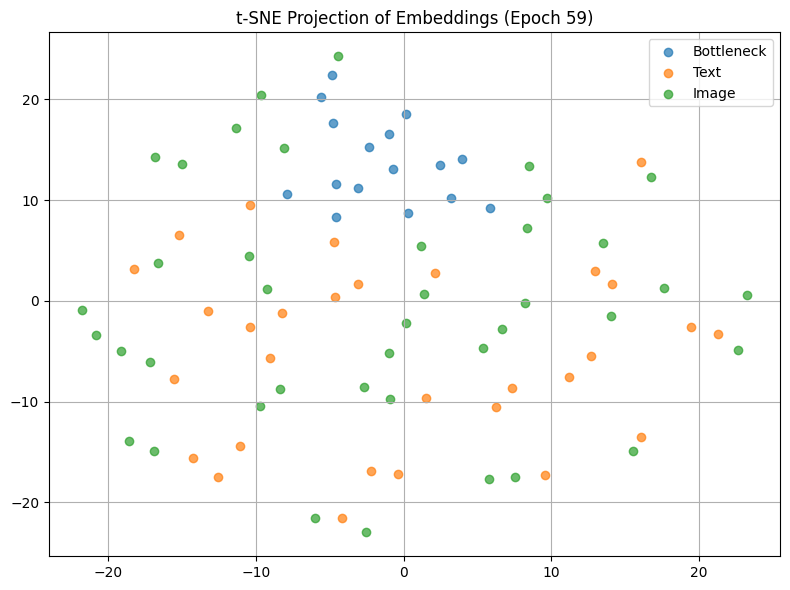

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 60] Loss: 20.4234 | Bottleneck STD: 0.009860 | Mean Similarity: 0.2126 | Div Loss: 0.026498 | Var Loss: 0.000140
Avg max sim to text:  0.1100
Avg max sim to image: 0.1053


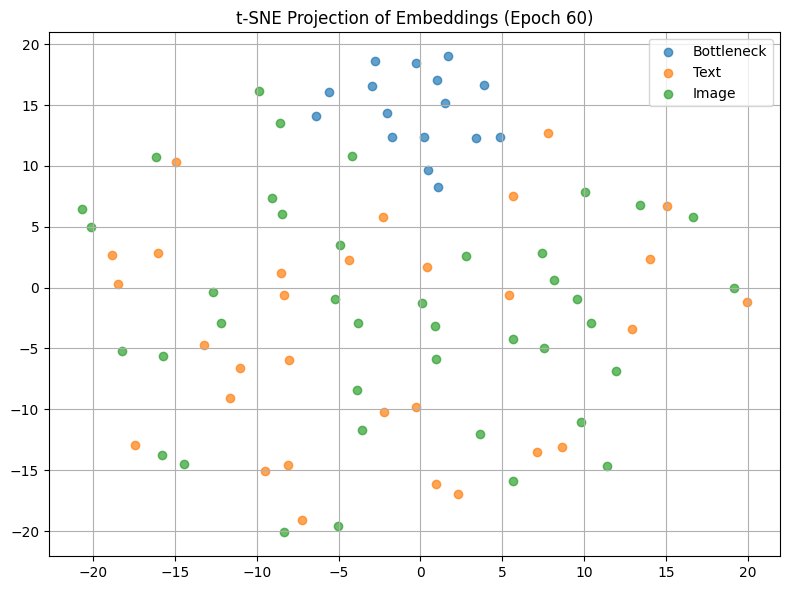

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 61] Loss: 11.6539 | Bottleneck STD: 0.009886 | Mean Similarity: 0.1689 | Div Loss: 0.013824 | Var Loss: 0.000114
Avg max sim to text:  0.1038
Avg max sim to image: 0.1117


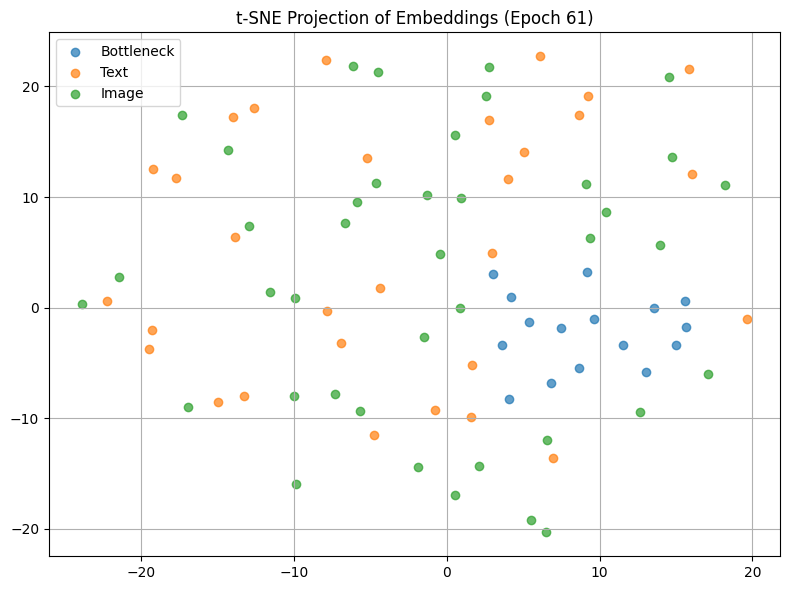

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 62] Loss: 13.0130 | Bottleneck STD: 0.009833 | Mean Similarity: 0.1756 | Div Loss: 0.015712 | Var Loss: 0.000167
Avg max sim to text:  0.0987
Avg max sim to image: 0.1036


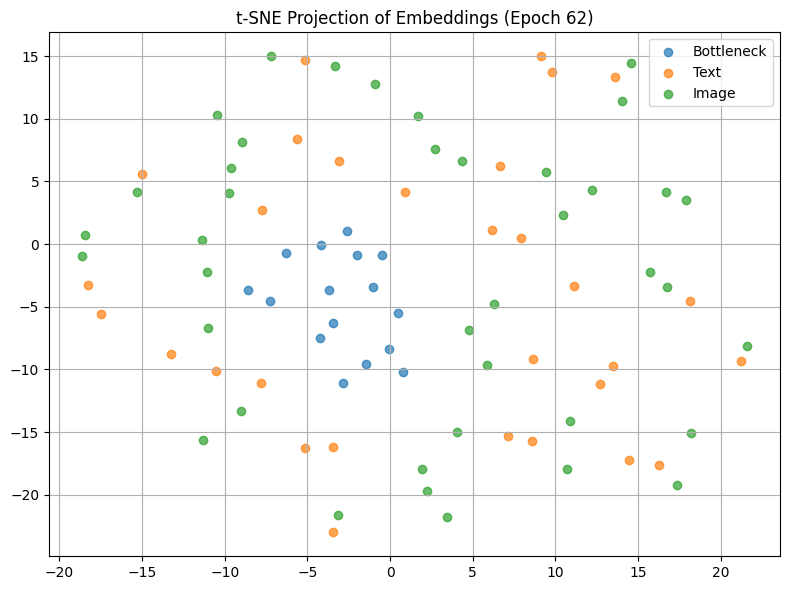

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 63] Loss: 12.5272 | Bottleneck STD: 0.009902 | Mean Similarity: 0.1719 | Div Loss: 0.015049 | Var Loss: 0.000098
Avg max sim to text:  0.0955
Avg max sim to image: 0.1029


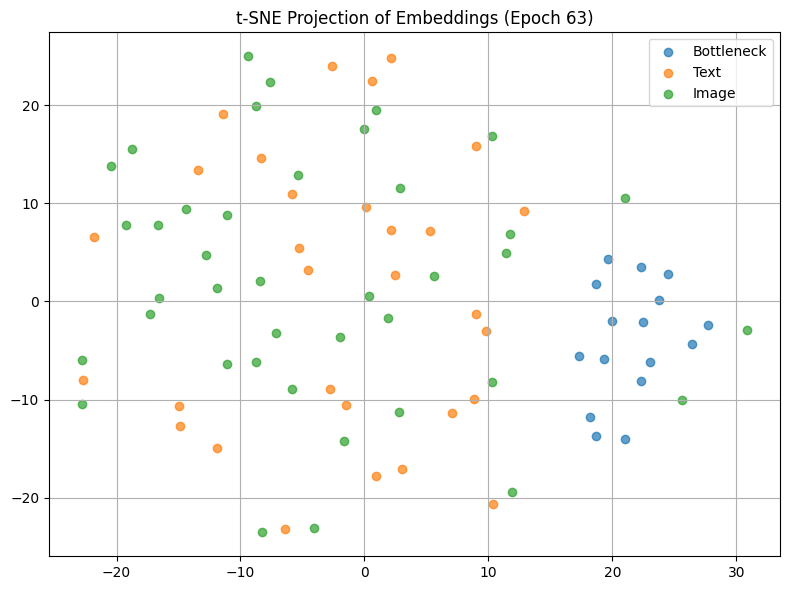

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 64] Loss: 11.7553 | Bottleneck STD: 0.009849 | Mean Similarity: 0.1669 | Div Loss: 0.013898 | Var Loss: 0.000151
Avg max sim to text:  0.1066
Avg max sim to image: 0.0966


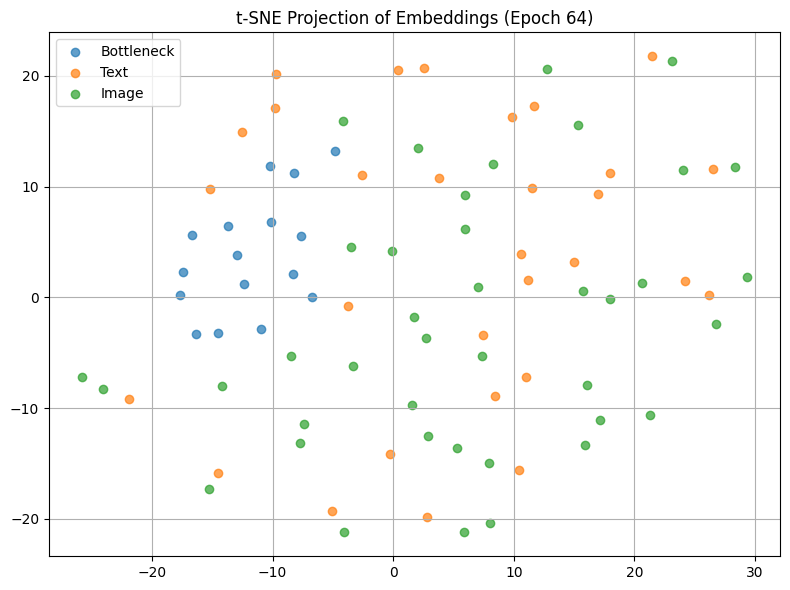

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 65] Loss: 11.4963 | Bottleneck STD: 0.009723 | Mean Similarity: 0.1619 | Div Loss: 0.013555 | Var Loss: 0.000277
Avg max sim to text:  0.0923
Avg max sim to image: 0.1147


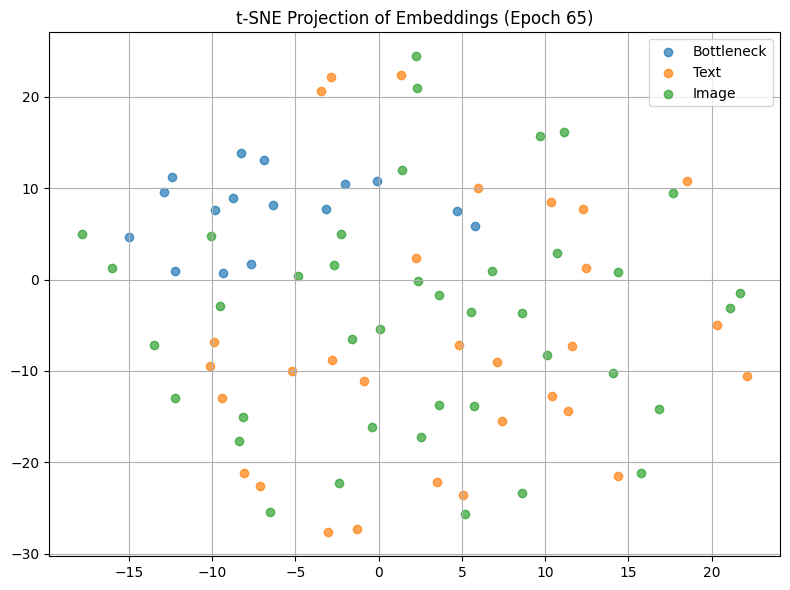

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 66] Loss: 14.6352 | Bottleneck STD: 0.009654 | Mean Similarity: 0.1835 | Div Loss: 0.018032 | Var Loss: 0.000346
Avg max sim to text:  0.0963
Avg max sim to image: 0.1090


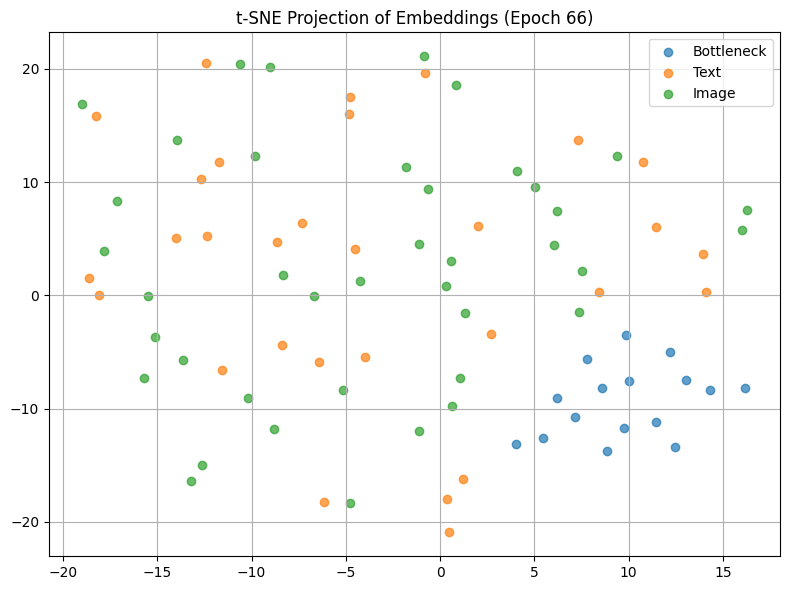

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 67] Loss: 9.5290 | Bottleneck STD: 0.009794 | Mean Similarity: 0.1535 | Div Loss: 0.010876 | Var Loss: 0.000206
Avg max sim to text:  0.1151
Avg max sim to image: 0.1063


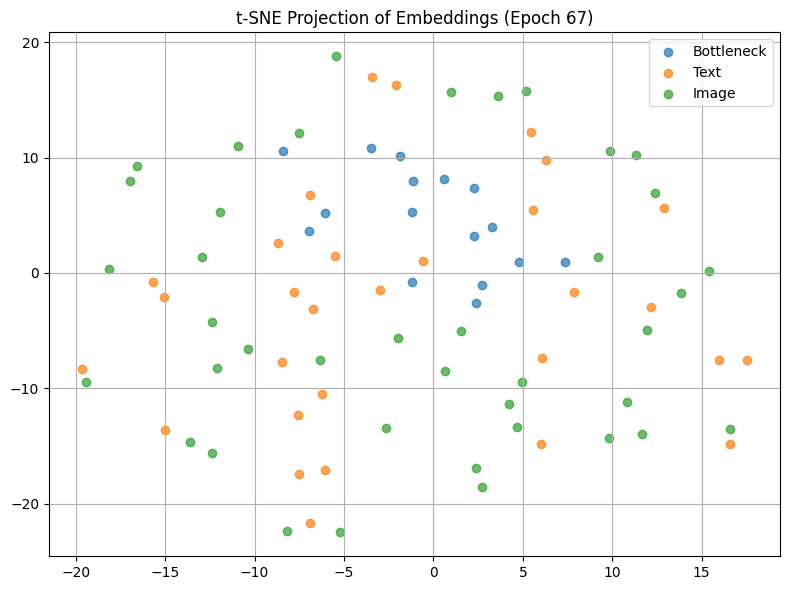

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 68] Loss: 10.4244 | Bottleneck STD: 0.009970 | Mean Similarity: 0.1590 | Div Loss: 0.012299 | Var Loss: 0.000030
Avg max sim to text:  0.1148
Avg max sim to image: 0.1212


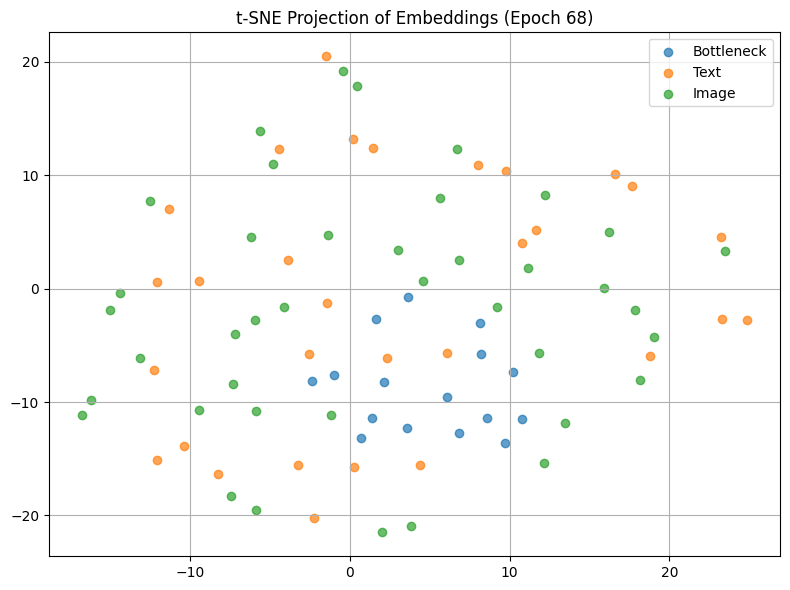

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 69] Loss: 10.0641 | Bottleneck STD: 0.009905 | Mean Similarity: 0.1583 | Div Loss: 0.011726 | Var Loss: 0.000095
Avg max sim to text:  0.1124
Avg max sim to image: 0.1127


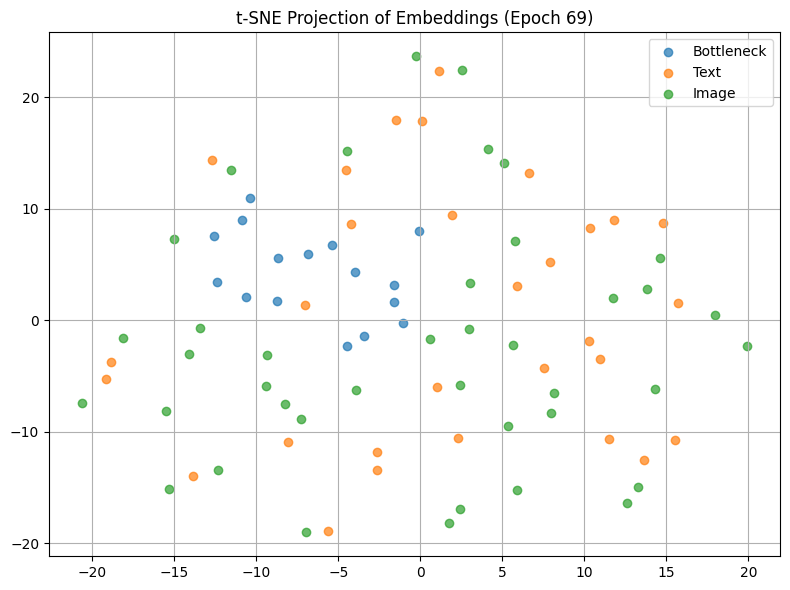

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 70] Loss: 8.6348 | Bottleneck STD: 0.009580 | Mean Similarity: 0.1461 | Div Loss: 0.009539 | Var Loss: 0.000420
Avg max sim to text:  0.1058
Avg max sim to image: 0.1172


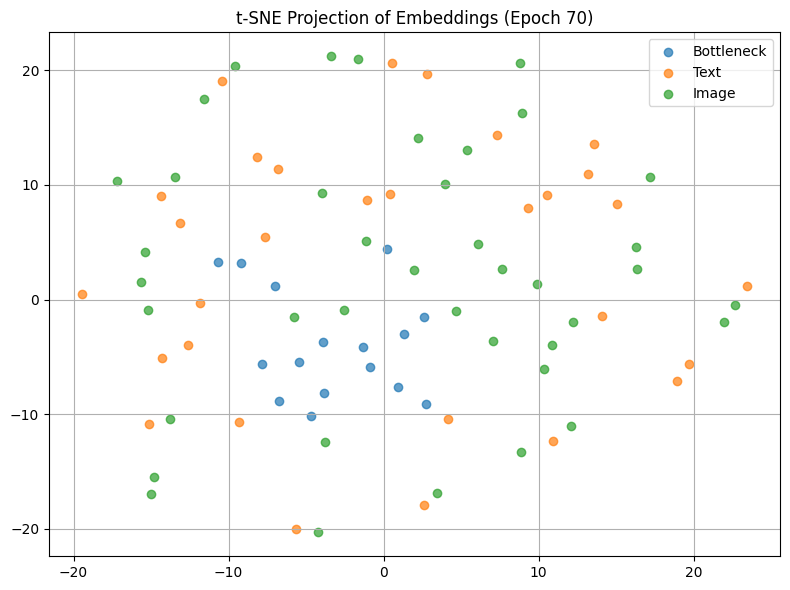

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 71] Loss: 11.1231 | Bottleneck STD: 0.009816 | Mean Similarity: 0.1632 | Div Loss: 0.013090 | Var Loss: 0.000184
Avg max sim to text:  0.1096
Avg max sim to image: 0.1038


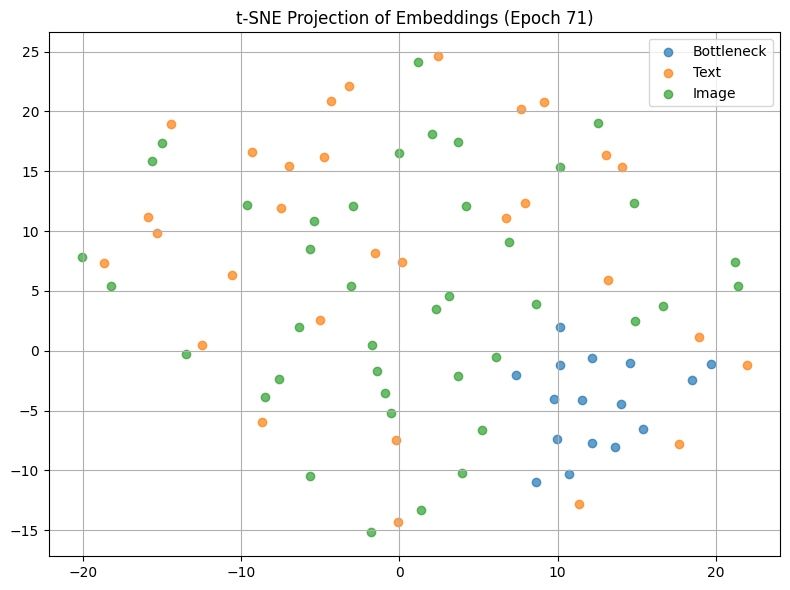

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 72] Loss: 8.0289 | Bottleneck STD: 0.009876 | Mean Similarity: 0.1390 | Div Loss: 0.008539 | Var Loss: 0.000124
Avg max sim to text:  0.1058
Avg max sim to image: 0.1011


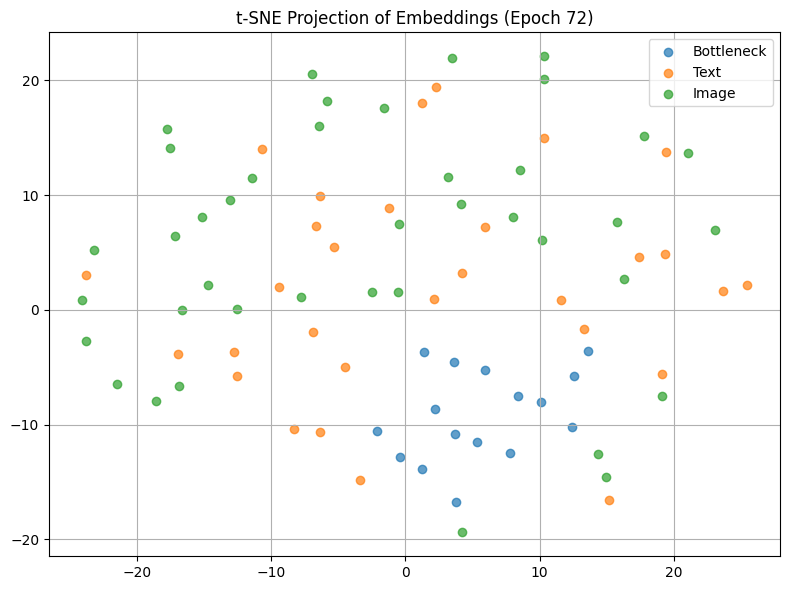

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 73] Loss: 10.3078 | Bottleneck STD: 0.009994 | Mean Similarity: 0.1556 | Div Loss: 0.011814 | Var Loss: 0.000006
Avg max sim to text:  0.1034
Avg max sim to image: 0.1010


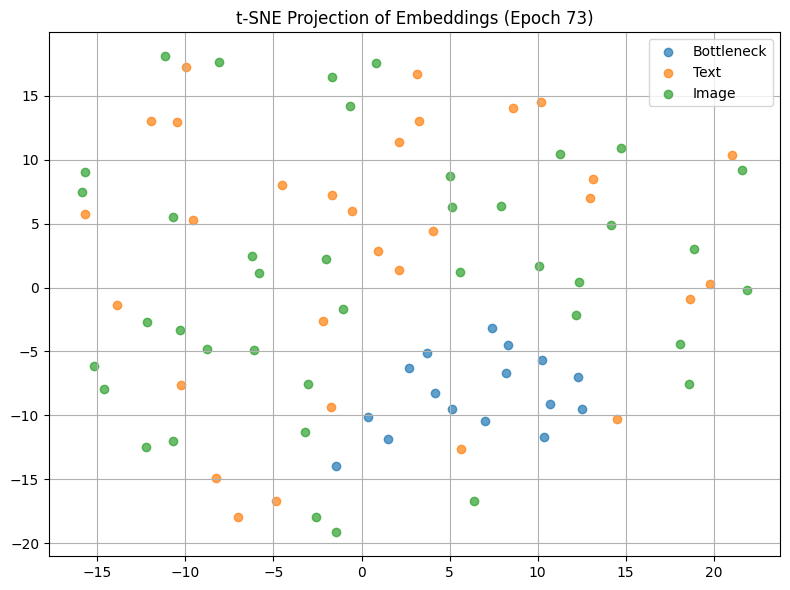

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 74] Loss: 10.4596 | Bottleneck STD: 0.009821 | Mean Similarity: 0.1593 | Div Loss: 0.012059 | Var Loss: 0.000179
Avg max sim to text:  0.1057
Avg max sim to image: 0.1074


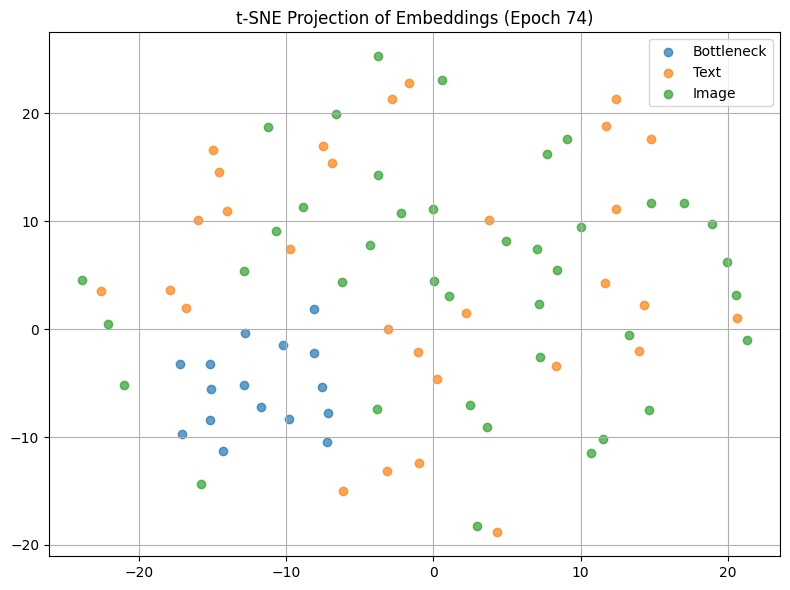

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 75] Loss: 7.0964 | Bottleneck STD: 0.009769 | Mean Similarity: 0.1336 | Div Loss: 0.007401 | Var Loss: 0.000231
Avg max sim to text:  0.1153
Avg max sim to image: 0.1024


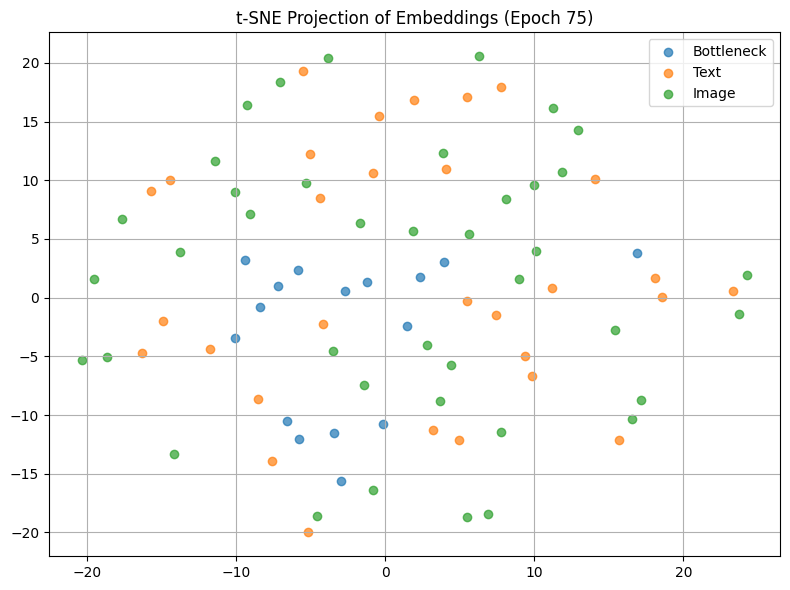

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 76] Loss: 11.3832 | Bottleneck STD: 0.009875 | Mean Similarity: 0.1670 | Div Loss: 0.013562 | Var Loss: 0.000125
Avg max sim to text:  0.0932
Avg max sim to image: 0.1250


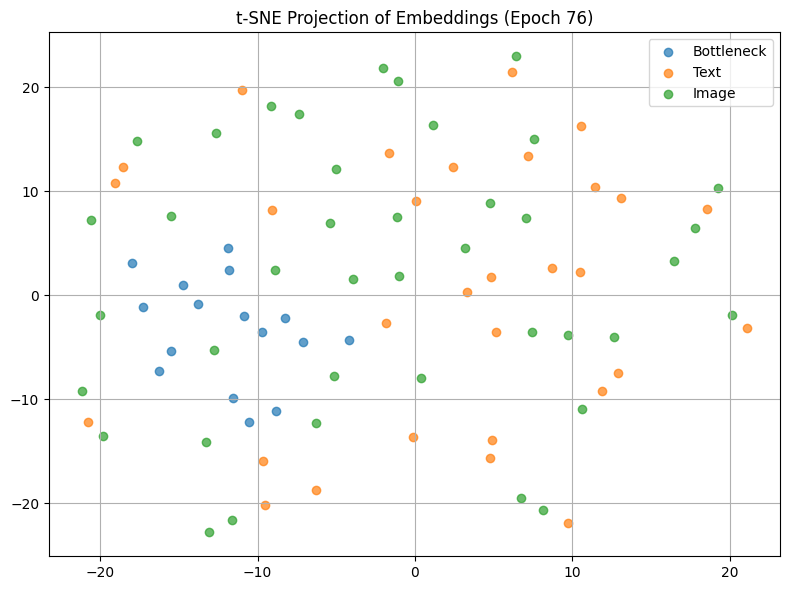

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 77] Loss: 8.3536 | Bottleneck STD: 0.009899 | Mean Similarity: 0.1452 | Div Loss: 0.009207 | Var Loss: 0.000101
Avg max sim to text:  0.1090
Avg max sim to image: 0.1106


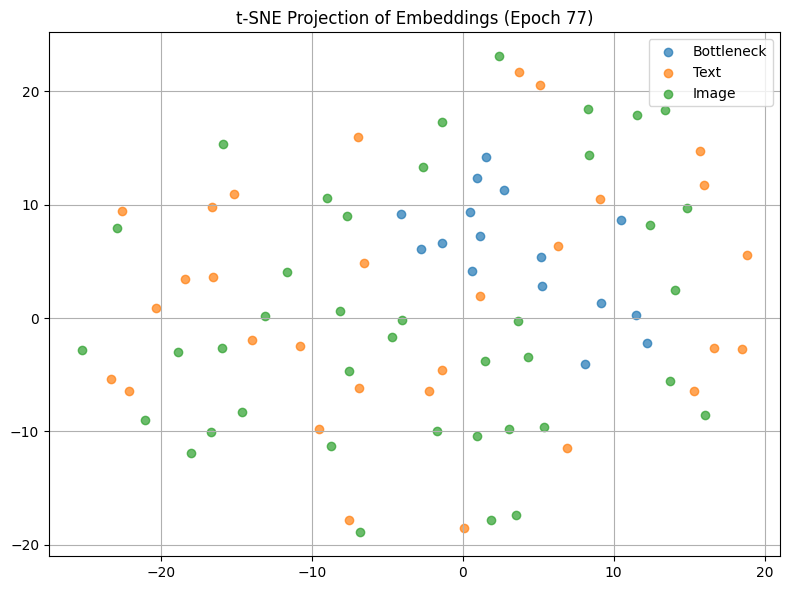

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 78] Loss: 11.4666 | Bottleneck STD: 0.009863 | Mean Similarity: 0.1646 | Div Loss: 0.013576 | Var Loss: 0.000137
Avg max sim to text:  0.1047
Avg max sim to image: 0.1171


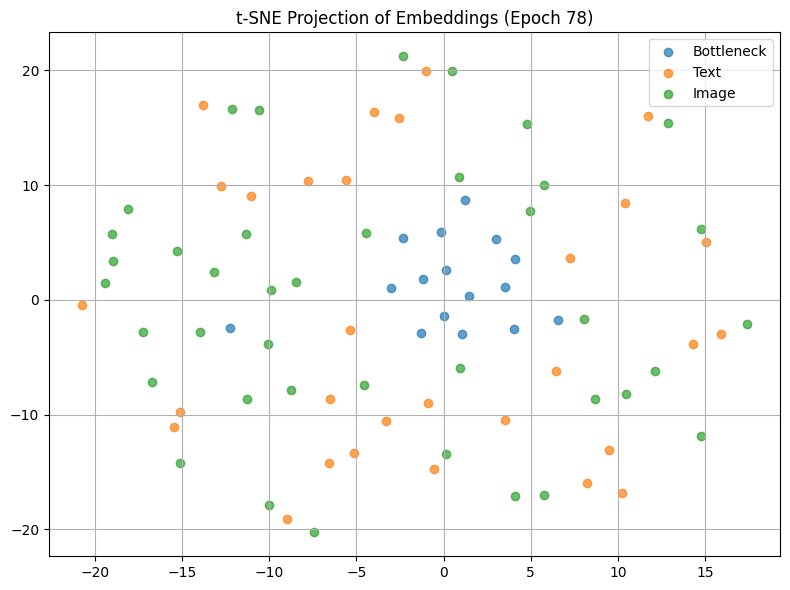

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 79] Loss: 10.6554 | Bottleneck STD: 0.009724 | Mean Similarity: 0.1600 | Div Loss: 0.012380 | Var Loss: 0.000276
Avg max sim to text:  0.0963
Avg max sim to image: 0.1113


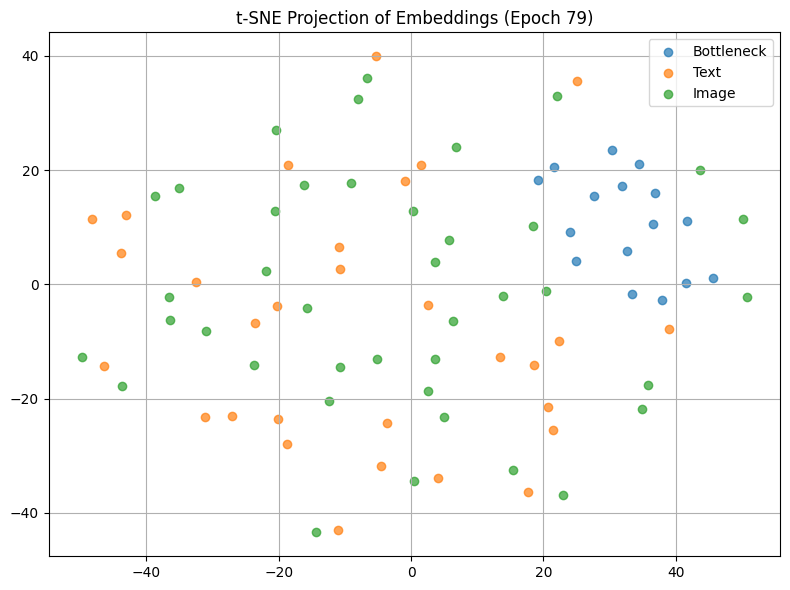

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 80] Loss: 11.7014 | Bottleneck STD: 0.009750 | Mean Similarity: 0.1676 | Div Loss: 0.013948 | Var Loss: 0.000250
Avg max sim to text:  0.1029
Avg max sim to image: 0.1114


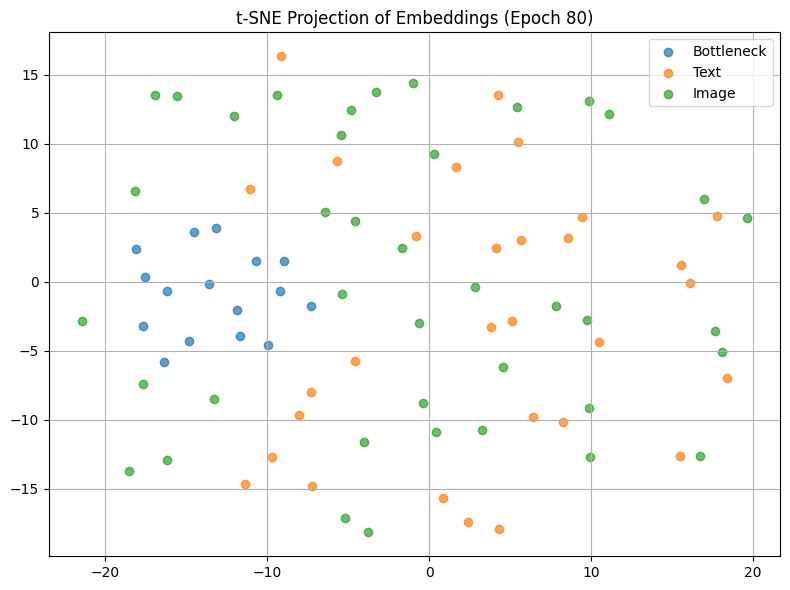

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 81] Loss: 8.9514 | Bottleneck STD: 0.009801 | Mean Similarity: 0.1482 | Div Loss: 0.010127 | Var Loss: 0.000199
Avg max sim to text:  0.1110
Avg max sim to image: 0.1124


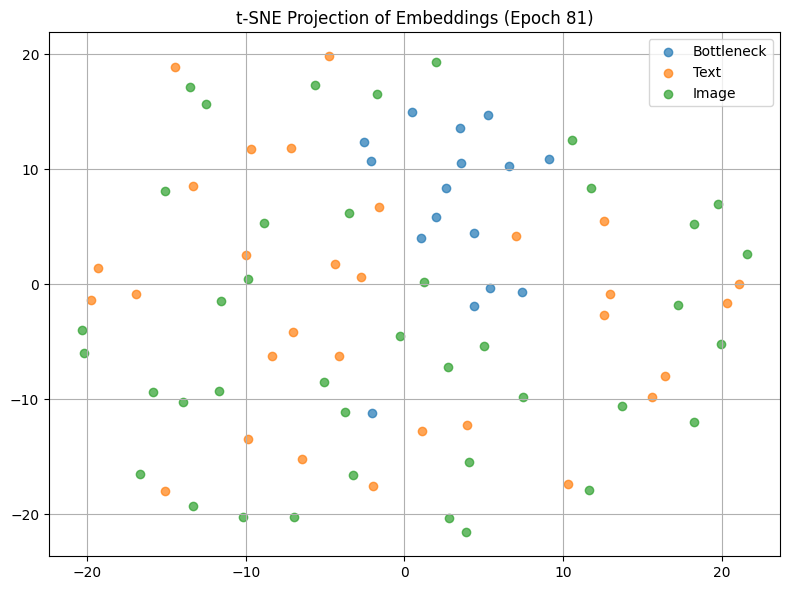

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 82] Loss: 10.6217 | Bottleneck STD: 0.009825 | Mean Similarity: 0.1596 | Div Loss: 0.012404 | Var Loss: 0.000175
Avg max sim to text:  0.1002
Avg max sim to image: 0.1198


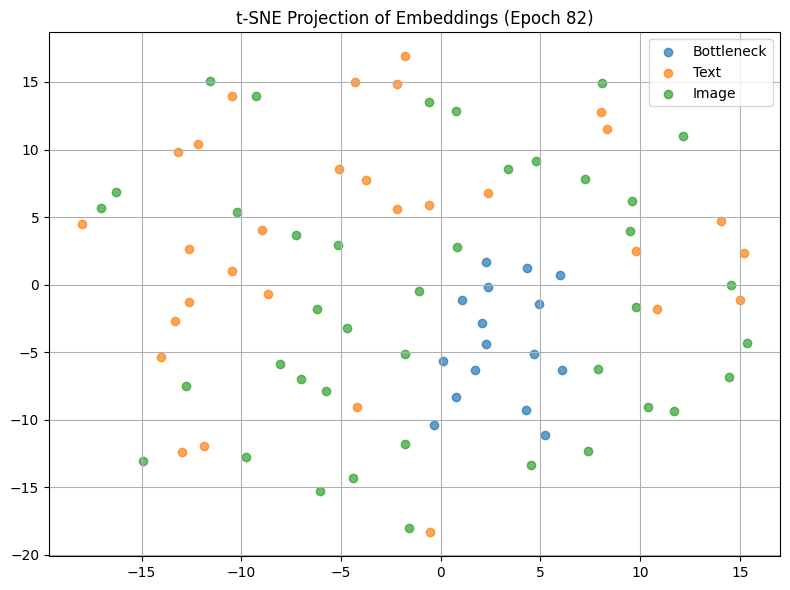

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 83] Loss: 9.0747 | Bottleneck STD: 0.009853 | Mean Similarity: 0.1465 | Div Loss: 0.010238 | Var Loss: 0.000147
Avg max sim to text:  0.1022
Avg max sim to image: 0.1241


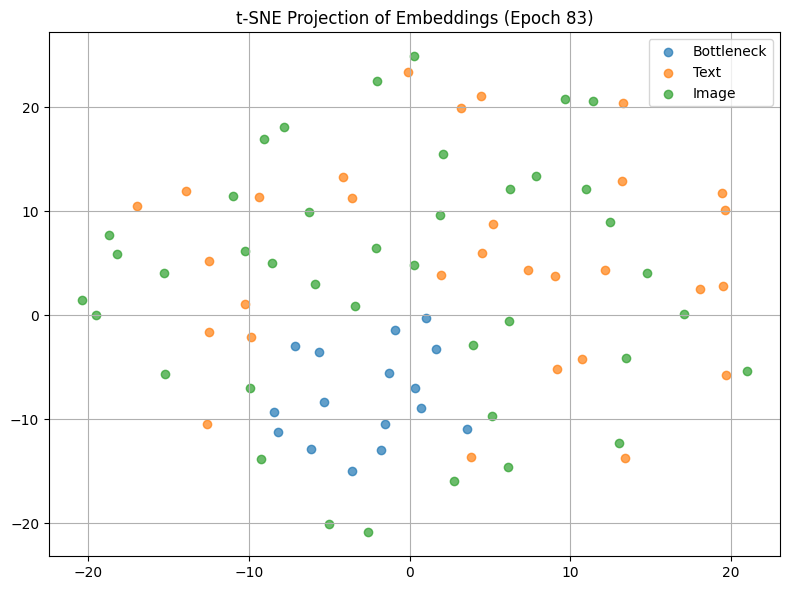

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 84] Loss: 11.1748 | Bottleneck STD: 0.009882 | Mean Similarity: 0.1638 | Div Loss: 0.013091 | Var Loss: 0.000118
Avg max sim to text:  0.0984
Avg max sim to image: 0.1061


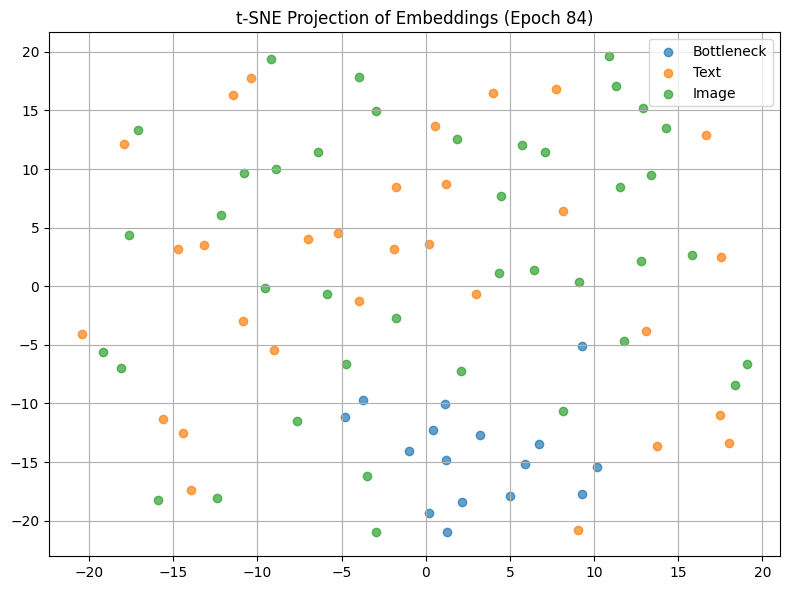

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 85] Loss: 10.4854 | Bottleneck STD: 0.009897 | Mean Similarity: 0.1595 | Div Loss: 0.012222 | Var Loss: 0.000103
Avg max sim to text:  0.1119
Avg max sim to image: 0.1164


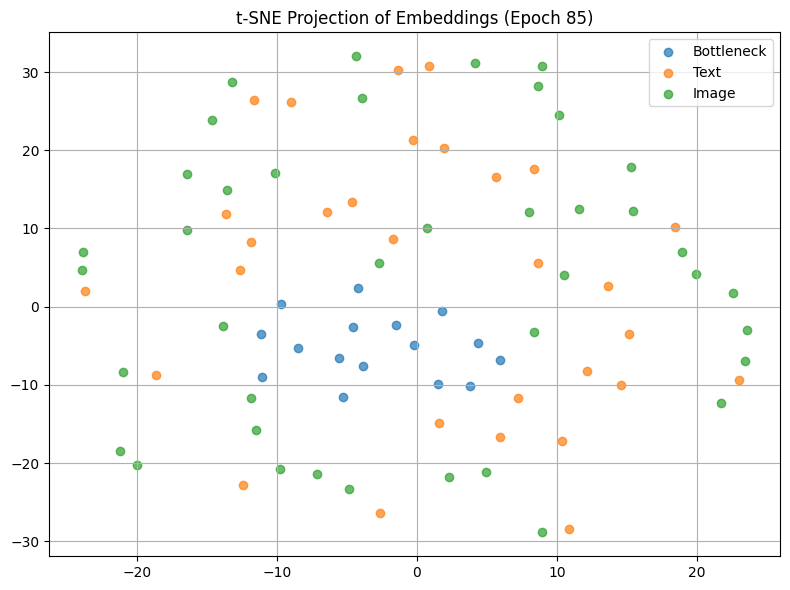

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 86] Loss: 8.1915 | Bottleneck STD: 0.009901 | Mean Similarity: 0.1397 | Div Loss: 0.008853 | Var Loss: 0.000099
Avg max sim to text:  0.0964
Avg max sim to image: 0.0962


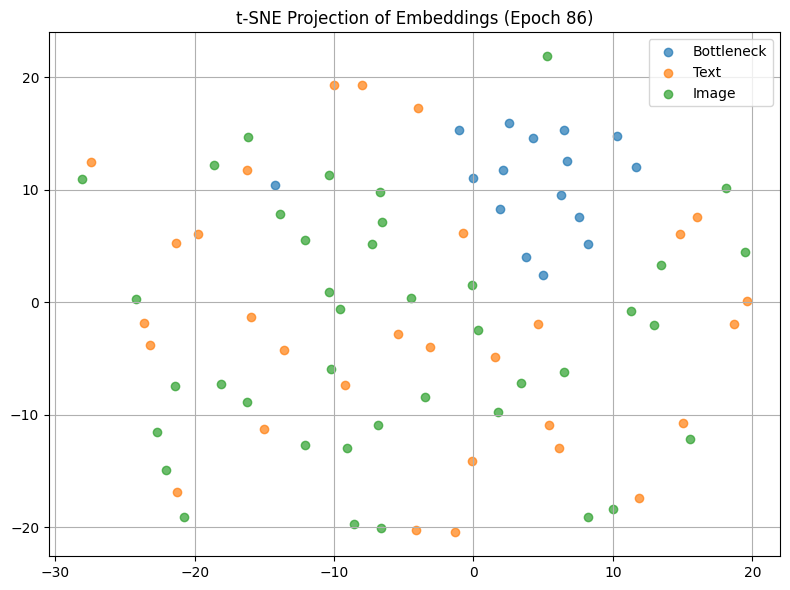

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 87] Loss: 15.6461 | Bottleneck STD: 0.009865 | Mean Similarity: 0.1873 | Div Loss: 0.019659 | Var Loss: 0.000135
Avg max sim to text:  0.1050
Avg max sim to image: 0.1202


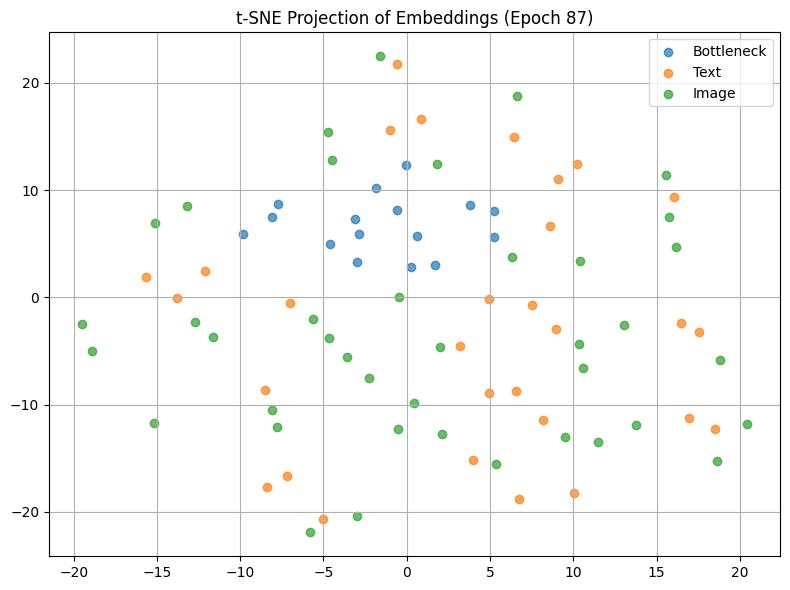

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 88] Loss: 9.8936 | Bottleneck STD: 0.009887 | Mean Similarity: 0.1559 | Div Loss: 0.011245 | Var Loss: 0.000113
Avg max sim to text:  0.1115
Avg max sim to image: 0.1049


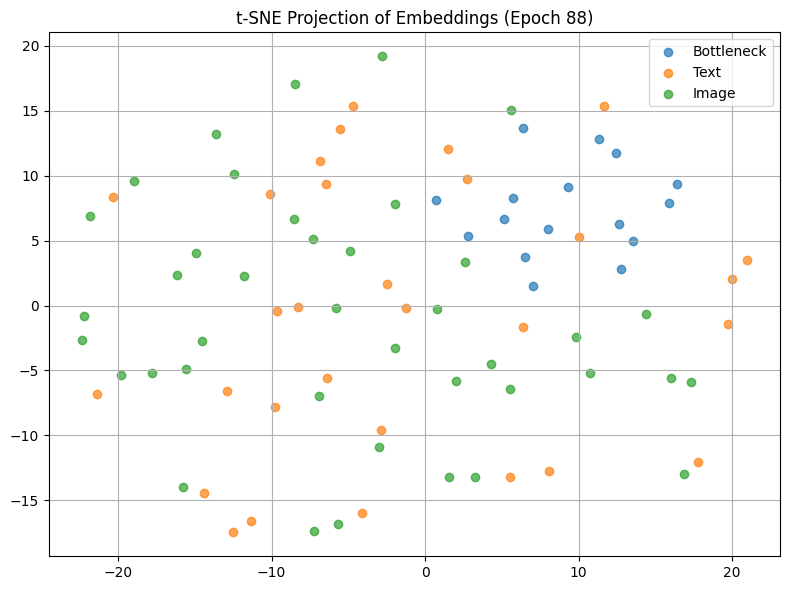

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 89] Loss: 14.8112 | Bottleneck STD: 0.009848 | Mean Similarity: 0.1832 | Div Loss: 0.018339 | Var Loss: 0.000152
Avg max sim to text:  0.1068
Avg max sim to image: 0.0970


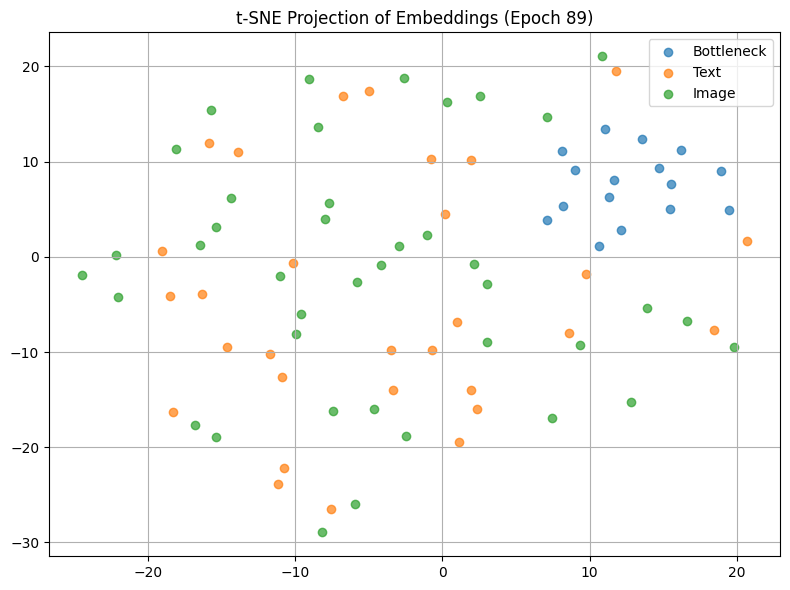

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 90] Loss: 11.0334 | Bottleneck STD: 0.009934 | Mean Similarity: 0.1623 | Div Loss: 0.012895 | Var Loss: 0.000066
Avg max sim to text:  0.0955
Avg max sim to image: 0.1103


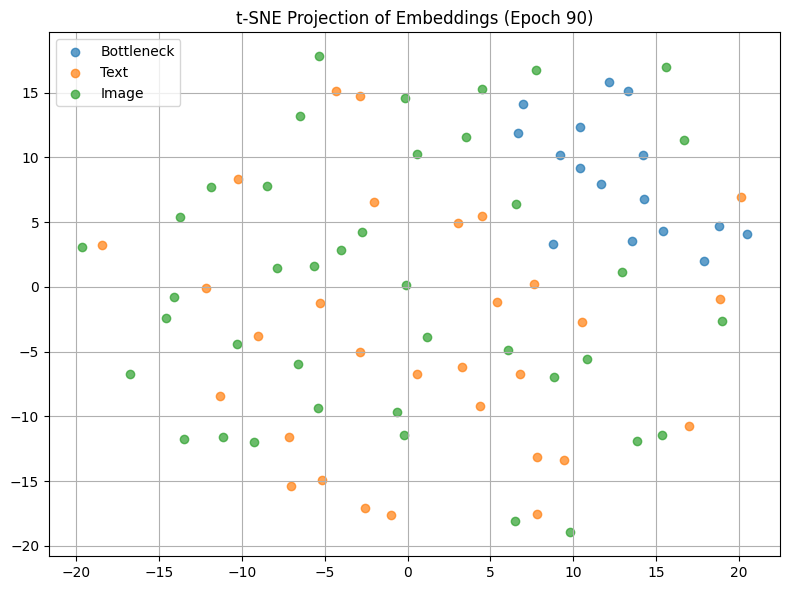

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 91] Loss: 14.3697 | Bottleneck STD: 0.009923 | Mean Similarity: 0.1846 | Div Loss: 0.017799 | Var Loss: 0.000077
Avg max sim to text:  0.1068
Avg max sim to image: 0.1111


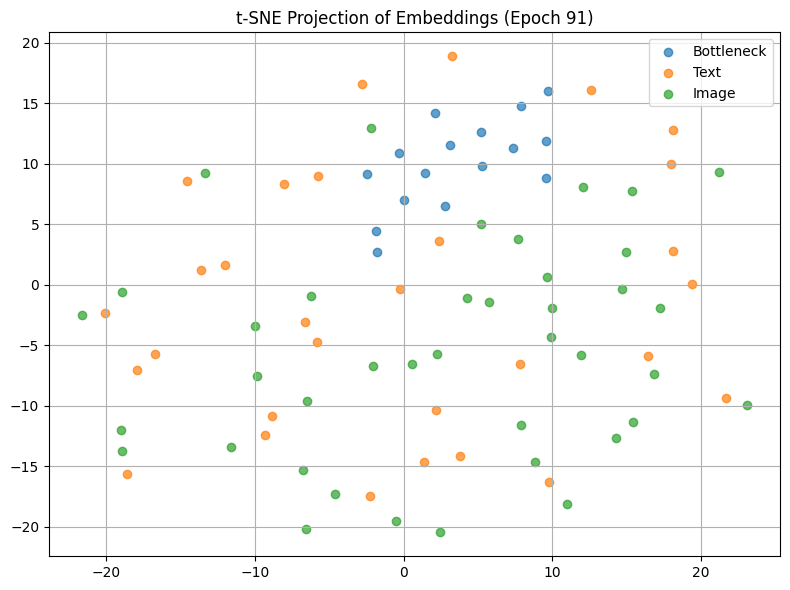

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 92] Loss: 10.6716 | Bottleneck STD: 0.009956 | Mean Similarity: 0.1597 | Div Loss: 0.012542 | Var Loss: 0.000044
Avg max sim to text:  0.1259
Avg max sim to image: 0.0985


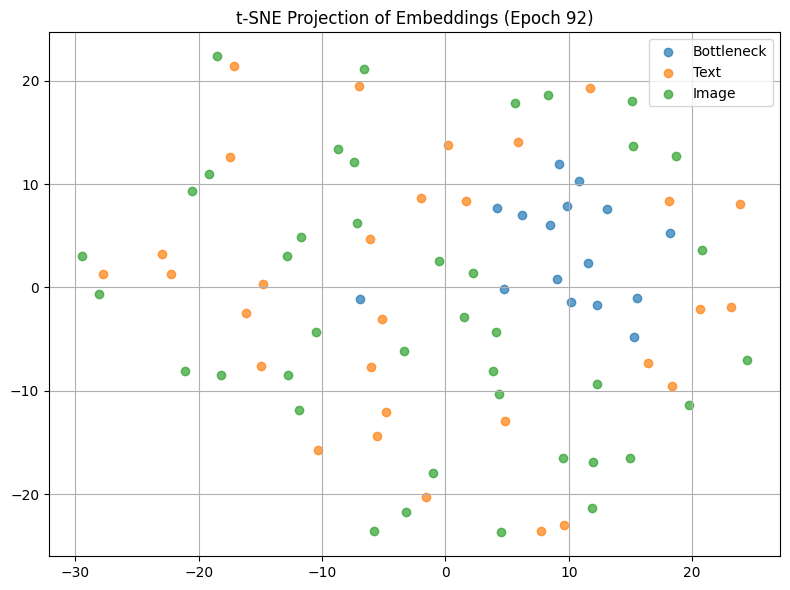

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 93] Loss: 11.6232 | Bottleneck STD: 0.009844 | Mean Similarity: 0.1680 | Div Loss: 0.013748 | Var Loss: 0.000156
Avg max sim to text:  0.1094
Avg max sim to image: 0.1051


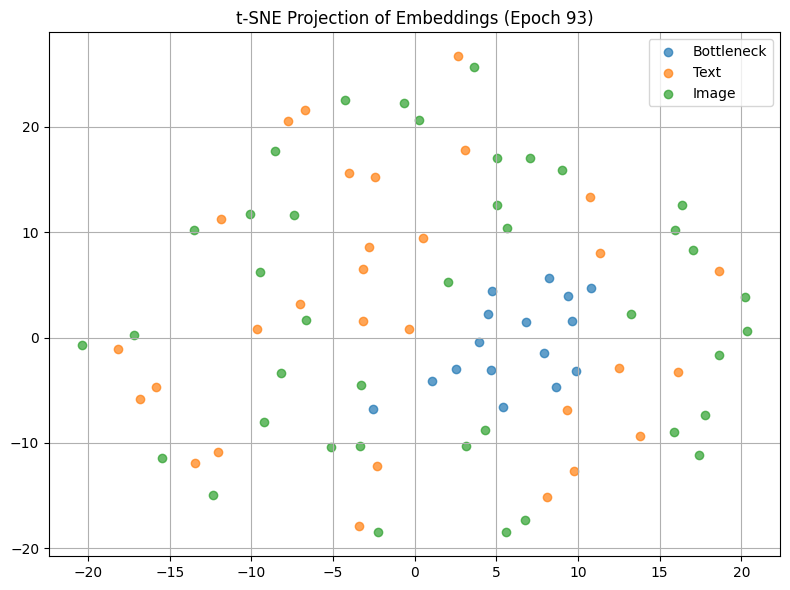

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 94] Loss: 10.8467 | Bottleneck STD: 0.009811 | Mean Similarity: 0.1634 | Div Loss: 0.012699 | Var Loss: 0.000189
Avg max sim to text:  0.1136
Avg max sim to image: 0.1101


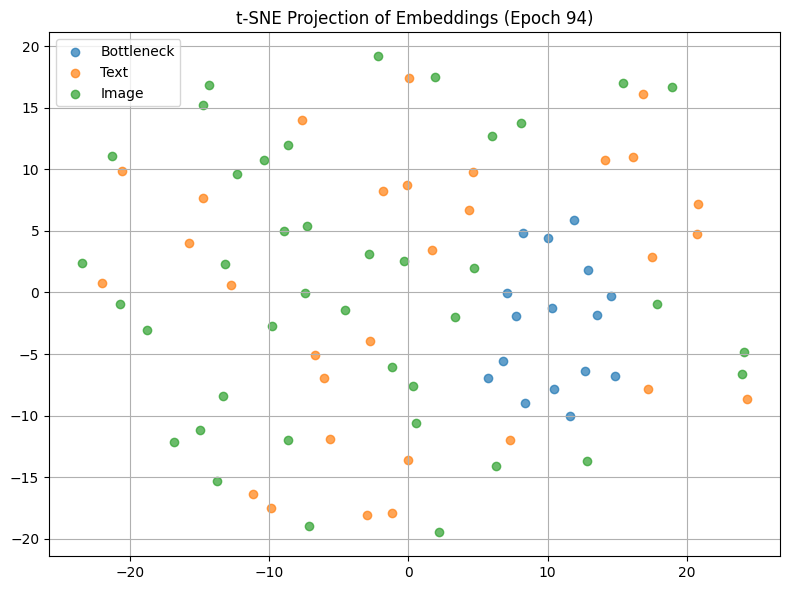

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 95] Loss: 15.1273 | Bottleneck STD: 0.009770 | Mean Similarity: 0.1895 | Div Loss: 0.018772 | Var Loss: 0.000230
Avg max sim to text:  0.1090
Avg max sim to image: 0.1178


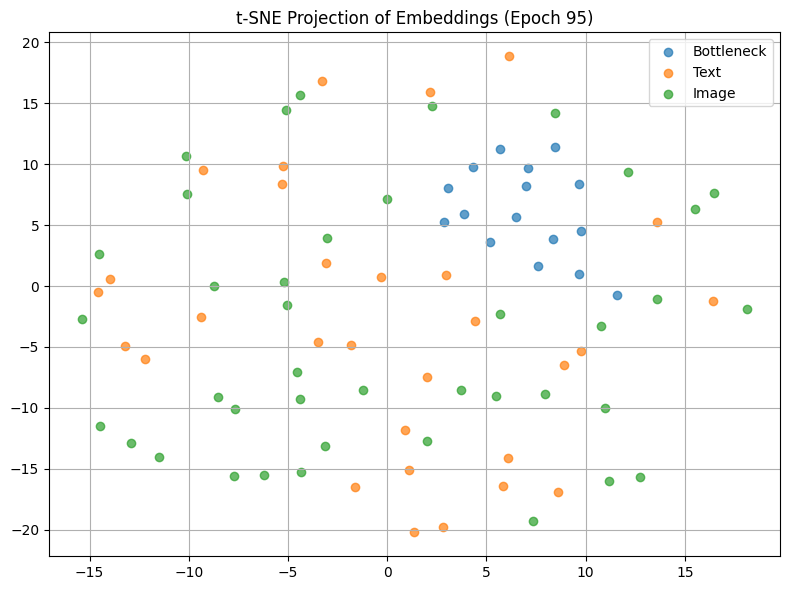

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 96] Loss: 9.7286 | Bottleneck STD: 0.009851 | Mean Similarity: 0.1524 | Div Loss: 0.011145 | Var Loss: 0.000149
Avg max sim to text:  0.1008
Avg max sim to image: 0.1310


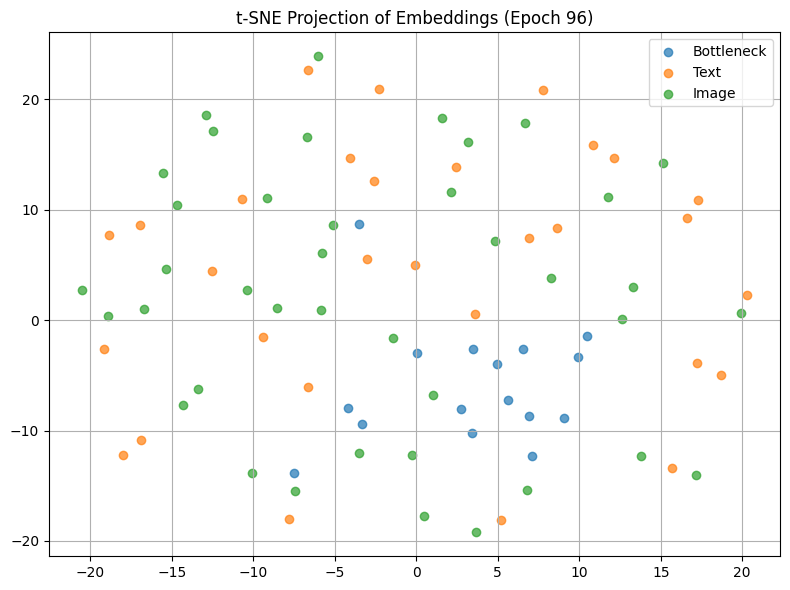

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 97] Loss: 18.2997 | Bottleneck STD: 0.009820 | Mean Similarity: 0.2048 | Div Loss: 0.023446 | Var Loss: 0.000180
Avg max sim to text:  0.1132
Avg max sim to image: 0.1168


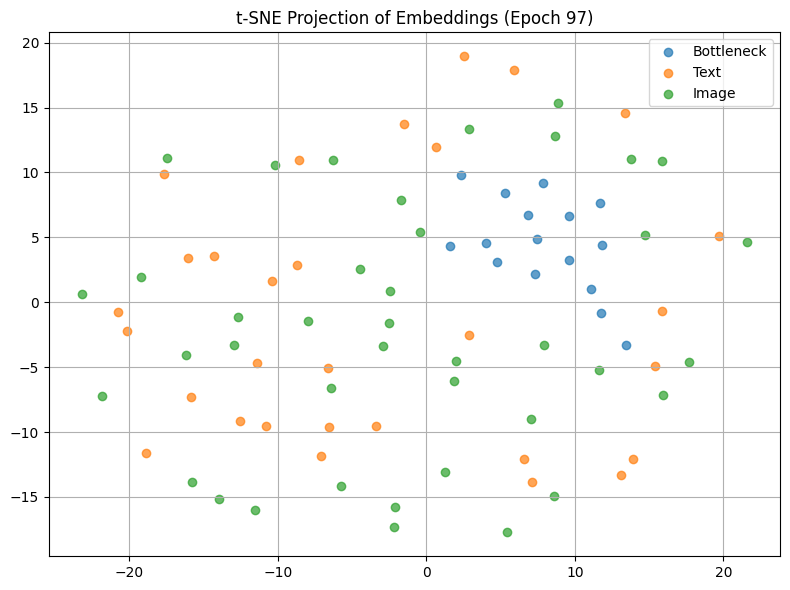

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 98] Loss: 12.3631 | Bottleneck STD: 0.009753 | Mean Similarity: 0.1703 | Div Loss: 0.014967 | Var Loss: 0.000247
Avg max sim to text:  0.1191
Avg max sim to image: 0.1127


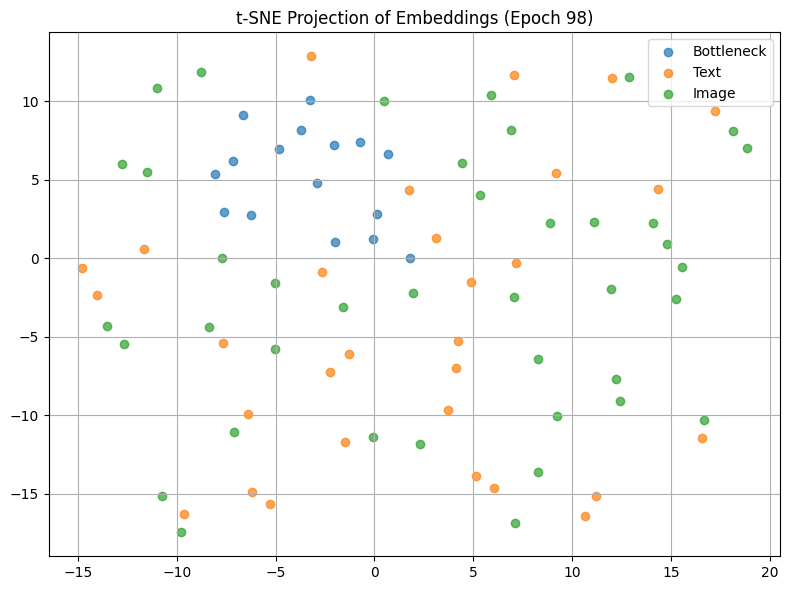

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 99] Loss: 16.2263 | Bottleneck STD: 0.009928 | Mean Similarity: 0.1914 | Div Loss: 0.020312 | Var Loss: 0.000072
Avg max sim to text:  0.0993
Avg max sim to image: 0.1132


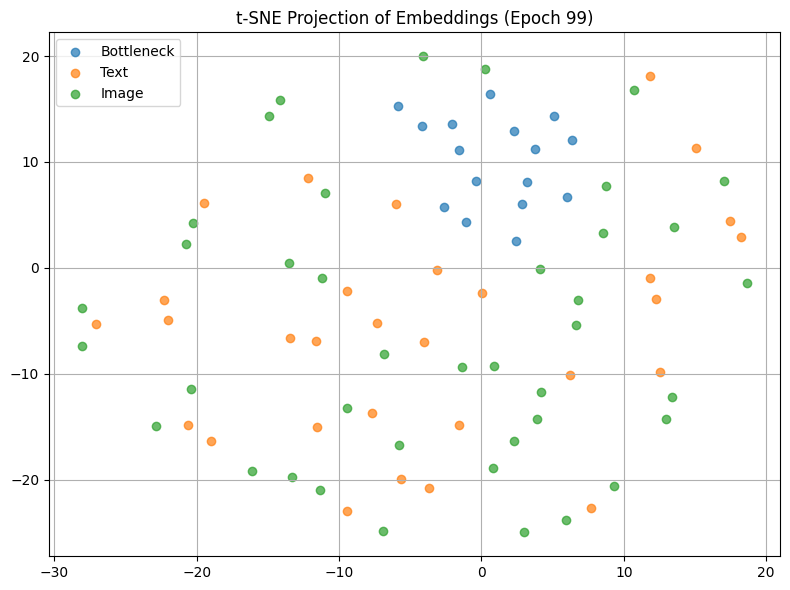

bottleneck_tokens: cuda:0
cross_attn_img.in_proj_weight: cuda:0
cross_attn_txt.in_proj_weight: cuda:0
[Epoch 100] Loss: 14.9717 | Bottleneck STD: 0.009920 | Mean Similarity: 0.1874 | Div Loss: 0.018608 | Var Loss: 0.000080
Avg max sim to text:  0.1203
Avg max sim to image: 0.1194


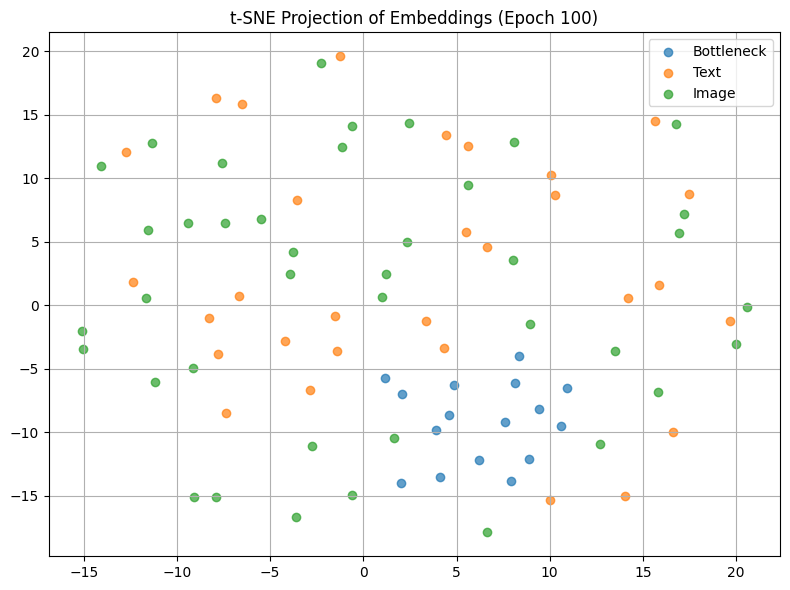

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy data (replace with real data)
text_embeddings = torch.randn(30, 384).to(device)   # (N, 384)
image_embeddings = torch.randn(40, 384).to(device)  # (M, 384)

# Model
model = BottleneckAttention(dim=384, num_heads=6, num_bottlenecks=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Loss functions ---
def cosine_contrastive_loss(anchor, positive):
    anchor = F.normalize(anchor, dim=-1)
    positive = F.normalize(positive, dim=-1)
    sim = F.cosine_similarity(anchor, positive, dim=-1)
    return (1 - sim).mean()

def diversity_loss(bottlenecks):
    b = F.normalize(bottlenecks, dim=-1)  # (B, D)
    sim_matrix = torch.matmul(b, b.T)
    identity = torch.eye(b.size(0), device=b.device)
    return ((sim_matrix - identity) ** 2).mean()

def variance_loss(tokens):
    return torch.clamp(0.01 - tokens.std(dim=0).mean(), min=0)

# --- Plot helper ---
from sklearn.manifold import TSNE

def plot_similarities(bottleneck, text, image, epoch, use_tsne=False):
    # Normalize tensors
    b = F.normalize(bottleneck, dim=-1)  # (16, 384)
    t = F.normalize(text, dim=-1)        # (30, 384)
    v = F.normalize(image, dim=-1)       # (40, 384)

    # Cosine similarity from PyTorch tensors
    sim_to_text = torch.matmul(b, t.T)   # (16, 30)
    sim_to_image = torch.matmul(b, v.T)  # (16, 40)

    print(f"Avg max sim to text:  {sim_to_text.max(dim=1).values.mean().item():.4f}")
    print(f"Avg max sim to image: {sim_to_image.max(dim=1).values.mean().item():.4f}")

    # Convert to numpy for PCA/t-SNE
    b_np = b.detach().cpu().numpy()
    t_np = t.detach().cpu().numpy()
    v_np = v.detach().cpu().numpy()
    all_embeddings = np.vstack([b_np, t_np, v_np])
    labels = ["Bottleneck"] * len(b_np) + ["Text"] * len(t_np) + ["Image"] * len(v_np)

    if use_tsne:
        reducer = TSNE(n_components=2, perplexity=10, learning_rate=100, init='pca', random_state=42)
        reduced = reducer.fit_transform(all_embeddings)
        title = f"t-SNE Projection of Embeddings (Epoch {epoch})"
    else:
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(all_embeddings)
        title = f"PCA Projection of Embeddings (Epoch {epoch})"

    # Plot
    plt.figure(figsize=(8, 6))
    for label in ["Bottleneck", "Text", "Image"]:
        idxs = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=label, alpha=0.7)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Training loop ---
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    text_emb = text_embeddings.unsqueeze(0)   # (1, N, 384)
    image_emb = image_embeddings.unsqueeze(0) # (1, M, 384)

    # Forward pass
    b_out = model(text_emb, image_emb)        # (1, 16, 384)
    b_tokens = b_out.squeeze(0)               # (16, 384)

    # Optional: add noise regularization to prevent collapse
    b_tokens = b_tokens + torch.randn_like(b_tokens) * 0.01

    # Pooling
    b_mean = b_tokens.mean(dim=0, keepdim=True)      # (1, 384)
    t_mean = text_embeddings.mean(dim=0, keepdim=True)
    v_mean = image_embeddings.mean(dim=0, keepdim=True)

    # Losses
    loss_bt = cosine_contrastive_loss(b_mean, t_mean)
    loss_bi = cosine_contrastive_loss(b_mean, v_mean)
    loss_div = diversity_loss(b_tokens)
    loss_var = variance_loss(b_tokens)
    # diversity_weight = min(epoch / 10.0, 1.0) * 500
    total_loss = loss_bt + loss_bi + 700* loss_div + 10.0 * loss_var

    total_loss.backward()
    optimizer.step()

    # Cosine similarity between bottlenecks
    with torch.no_grad():
        b_norm = F.normalize(b_tokens, dim=-1)
        sim = torch.matmul(b_norm, b_norm.T)
        mean_sim = sim.mean().item()
        std_dev = b_tokens.std(dim=0).mean().item()

    print(f"[Epoch {epoch+1}] Loss: {total_loss.item():.4f} | "
          f"Bottleneck STD: {std_dev:.6f} | "
          f"Mean Similarity: {mean_sim:.4f} | "
          f"Div Loss: {loss_div.item():.6f} | Var Loss: {loss_var.item():.6f}")

    plot_similarities(bottleneck=b_tokens,
                  text=text_embeddings,
                  image=image_embeddings,
                  epoch=epoch+1,
                  use_tsne=True)  # <-- toggle here



In [ ]:
# import torch
# import torch.nn as nn

# class BottleneckAttention(nn.Module):
#     def __init__(self, dim=384, num_heads=6, num_bottlenecks=4):
#         super().__init__()
#         self.bottleneck_tokens = nn.Parameter(torch.randn(1, num_bottlenecks, dim))
#         self.cross_attn_img = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
#         self.cross_attn_txt = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

#     def forward(self, image_tokens, text_tokens):
#         B = image_tokens.shape[0]

#         # Expand bottleneck tokens to batch size
#         bottlenecks = self.bottleneck_tokens.expand(B, -1, -1)  # [B, B₀, D]

#         # --- Step 1: Tokens → Bottlenecks (Tokens attend to bottlenecks)
#         # Image attends to bottlenecks
#         img_out, _ = self.cross_attn_img(query=image_tokens, key=bottlenecks, value=bottlenecks)

#         # Text attends to bottlenecks
#         txt_out, _ = self.cross_attn_txt(query=text_tokens, key=bottlenecks, value=bottlenecks)

#         # --- Step 2: Bottlenecks → Tokens (Bottlenecks attend to each modality)
#         # Bottlenecks attend to image
#         bn_img, _ = self.cross_attn_img(query=bottlenecks, key=img_out, value=img_out)

#         # Bottlenecks attend to text
#         bn_txt, _ = self.cross_attn_txt(query=bottlenecks, key=txt_out, value=txt_out)

#         # Combine (optional: sum, cat, etc.)
#         fused = bn_img + bn_txt  # [B, B₀, D]

#         return fused

# import torch
# import torch.nn as nn

# # Define the bottleneck cross-attention module
# class BottleneckAttention(nn.Module):
#     def __init__(self, dim=384, num_heads=6, num_bottlenecks=4):
#         super().__init__()
#         self.bottleneck_tokens = nn.Parameter(torch.randn(1, num_bottlenecks, dim))
#         self.cross_attn_img = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
#         self.cross_attn_txt = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

#     def forward(self, image_tokens, text_tokens):
#         B = image_tokens.shape[0]
#         bottlenecks = self.bottleneck_tokens.expand(B, -1, -1)  # [B, B₀, D]

#         # Step 1: Image and text attend to bottlenecks
#         img_attended, _ = self.cross_attn_img(query=image_tokens, key=bottlenecks, value=bottlenecks)
#         txt_attended, _ = self.cross_attn_txt(query=text_tokens, key=bottlenecks, value=bottlenecks)

#         # Step 2: Bottlenecks attend back to attended image/text
#         bn_img, _ = self.cross_attn_img(query=bottlenecks, key=img_attended, value=img_attended)
#         bn_txt, _ = self.cross_attn_txt(query=bottlenecks, key=txt_attended, value=txt_attended)

#         # Combine bottleneck outputs
#         fused = bn_img + bn_txt  # or torch.cat([...], dim=-1)
#         return fused

# # Dummy input: batch of 1, 10 image tokens, 20 text tokens, all of dim 384
# batch_size = 1

# # Initialize and run the model
# model = BottleneckAttention(dim=384, num_heads=6, num_bottlenecks=4)
# fused_output = model(image_tokens, text_tokens)

# # Output
# print("Fused output shape:", fused_output.shape)
# print("Fused output sample:\n", fused_output[0])

# bottleneck_tokens = fused_output[0].detach().cpu().numpy()  # shape: (num_bottlenecks, 384)
# text_embeddings = text_tokens.squeeze(0).detach().cpu().numpy()     # shape: (num_text_tokens, 384)
# image_embeddings = image_tokens.squeeze(0).detach().cpu().numpy()   # shape: (num_image_tokens, 384)
# print(bottleneck_tokens.shape)
# print(text_embeddings.shape)
# print(image_embeddings.shape)


# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BottleneckCrossAttention(nn.Module):
#     def __init__(self, dim, bottleneck_tokens=16, num_heads=4):
#         super().__init__()
#         self.bottleneck = nn.Parameter(torch.randn(1, bottleneck_tokens, dim))
#         self.cross_attn_text = nn.MultiheadAttention(dim, num_heads, batch_first=True)
#         self.cross_attn_image = nn.MultiheadAttention(dim, num_heads, batch_first=True)

#     def forward(self, text_emb, image_emb):
#       import torch

#       if not isinstance(text_emb, torch.Tensor):
#             text_emb = torch.tensor(text_emb, dtype=torch.float32)

#       B = text_emb.size(0)
#       b_tokens = self.bottleneck.expand(B, -1, -1)

#         # Bottleneck attends to text
#       b_to_text, _ = self.cross_attn_text(b_tokens, text_emb, text_emb)

#         # Bottleneck attends to image
#       b_to_image, _ = self.cross_attn_image(b_to_text, image_emb, image_emb)

#       return b_to_image


# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics.pairwise import cosine_similarity

# def plot_similarities(b_tokens, text_emb, image_emb, epoch):
#     sim_bt = cosine_similarity(b_tokens.detach().cpu().numpy(), text_emb.detach().cpu().numpy())
#     sim_bv = cosine_similarity(b_tokens.detach().cpu().numpy(), image_emb.detach().cpu().numpy())

#     fig, axes = plt.subplots(2, 1, figsize=(8, 8))
#     sns.heatmap(sim_bt, ax=axes[0], cmap="viridis")
#     axes[0].set_title(f"Bottleneck vs Text Similarity (Epoch {epoch})")

#     sns.heatmap(sim_bv, ax=axes[1], cmap="viridis")
#     axes[1].set_title(f"Bottleneck vs Image Similarity (Epoch {epoch})")
#     plt.tight_layout()
#     plt.show()


# import torch
# import torch.nn.functional as F
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Ensure you're on CPU or GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Assume you already have these from previous steps
# # fused_output, text_tokens, image_tokens

# model = BottleneckCrossAttention(dim=384, bottleneck_tokens=16).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # Convert to torch.Tensor
# bottleneck_tokens = fused_output[0].detach().to(device)        # (16, 384)
# text_embeddings = text_tokens.squeeze(0).detach().to(device)   # (N, 384)
# image_embeddings = image_tokens.squeeze(0).detach().to(device) # (M, 384)

# # --- Define plot helper ---
# from sklearn.decomposition import PCA

# def plot_similarities(bottleneck, text, image, epoch):
#     b = bottleneck.detach().cpu().numpy()
#     t = text.detach().cpu().numpy()
#     v = image.detach().cpu().numpy()

#     all_embeddings = np.vstack([b, t, v])
#     labels = (
#         ["Bottleneck"] * len(b) +
#         ["Text"] * len(t) +
#         ["Image"] * len(v)
#     )

#     pca = PCA(n_components=2)
#     reduced = pca.fit_transform(all_embeddings)

#     plt.figure(figsize=(8, 6))
#     for label in ["Bottleneck", "Text", "Image"]:
#         idxs = [i for i, l in enumerate(labels) if l == label]
#         plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=label, alpha=0.7)

#     plt.title(f"PCA Projection of Embeddings (Epoch {epoch})")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# # --- Training loop ---
# epochs = 10
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass
#     text_emb = text_embeddings.unsqueeze(0)   # (1, N, 384)
#     image_emb = image_embeddings.unsqueeze(0) # (1, M, 384)
#     b_out = model(text_emb, image_emb)        # (1, 16, 384)

#     # Mean of embeddings
#     b_mean = b_out.mean(dim=1)      # (1, 384)
#     t_mean = text_emb.mean(dim=1)   # (1, 384)
#     v_mean = image_emb.mean(dim=1)  # (1, 384)

#     # Loss: similarity to both text and image
#     loss = -F.cosine_similarity(b_mean, t_mean, dim=1).mean()
#     loss += -F.cosine_similarity(b_mean, v_mean, dim=1).mean()

#     loss.backward()
#     optimizer.step()

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

#     # Visualization
#     plot_similarities(b_out[0], text_embeddings, image_embeddings, epoch+1)


# i seem to have made an absolute mess of things can you fix it this is all the code after creating embeddings